In [1]:
# ===============================
# 1. Import Libraries and Load Data
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional, BatchNormalization, Input, Concatenate, Conv1D, MaxPooling1D, Flatten, Attention
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Hyperparameter Tuning
import keras_tuner as kt
import optuna

# Advanced Boosting Libraries
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
import catboost as cb

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Loading and preparing data for Bangkok AQI prediction model...")

# Load historical data
try:
    df = pd.read_csv('BangkokFinal.csv')
    print(f"Successfully loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
except FileNotFoundError:
    print("Warning: BangkokFinal.csv not found. Using sample data for demonstration.")
    # Create sample data for demonstration if file not found
    # This is just for code testing purposes
    from sklearn.datasets import make_regression
    X, y = make_regression(n_samples=1000, n_features=20, noise=0.1)
    sample_columns = ['date', 'name', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 
                      'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 
                      'feelslike', 'dew', 'humidity', 'precip', 'precipcover', 
                      'precipprob', 'preciptype', 'snow', 'snowdepth', 'windspeed', 
                      'winddir', 'windgust', 'sealevelpressure', 'cloudcover', 
                      'visibility', 'solarradiation', 'solarenergy', 'uvindex', 
                      'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions', 
                      'description', 'icon', 'stations']
    df = pd.DataFrame(np.random.randn(1000, len(sample_columns)), columns=sample_columns)
    df['date'] = pd.date_range(start='1/1/2014', periods=1000)
    df['conditions'] = np.random.choice(['Clear', 'Partially cloudy', 'Overcast', 
                                         'Rain, Partially cloudy', 'Rain, Overcast'], 1000)

Loading and preparing data for Bangkok AQI prediction model...
Successfully loaded data with 4045 rows and 39 columns


In [2]:
# ===============================
# 2. Data Cleaning and Preprocessing
# ===============================
print("\n--- Starting Data Cleaning and Preprocessing ---")

# Display initial data information
print("\nInitial data information:")
print(f"Shape: {df.shape}")
print("\nData types:")
print(df.dtypes.value_counts())
print("\nMissing values before cleaning:")
missing_before = df.isnull().sum()
print(missing_before[missing_before > 0])

# Drop unneeded columns
columns_to_drop = ['name', 'sunrise', 'sunset', 'description', 
                   'icon', 'stations','feelslikemax', 'feelslikemin', 
                   'feelslike', 'snow', 'snowdepth','precipcover', 
                   'precipprob', 'preciptype', 'windgust', 'moonphase',
                   'severerisk']
df.drop(columns=columns_to_drop, inplace=True)
print(f"\nDropped {len(columns_to_drop)} unnecessary columns")

# Convert date column to datetime and sort the data
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')
df = df.sort_values(by='date')
print(f"Converted date column to datetime. Date range: {df['date'].min()} to {df['date'].max()}")

# Add time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['season'] = pd.cut(df['month'], 
                     bins=[0, 3, 6, 9, 12], 
                     labels=['Winter', 'Spring', 'Summer', 'Fall'],
                     include_lowest=True)

# Add cyclical encoding for month and day of week
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year']/365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year']/365)

print("Added time-based features including cyclical encodings")

# Check for outliers in key variables
print("\nChecking for outliers in key pollution variables...")
for col in ['pm25', 'pm10', 'o3', 'no2', 'so2']:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        if not outliers.empty:
            print(f"{col}: {len(outliers)} outliers detected ({len(outliers)/len(df)*100:.2f}%)")
            # Cap outliers instead of removing them
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
            print(f"  Outliers capped at [{lower_bound:.2f}, {upper_bound:.2f}]")

# Handle missing values with advanced techniques
print("\nHandling missing values...")

# For pm10: forward fill, backward fill then average
if 'pm10' in df.columns and df['pm10'].isnull().sum() > 0:
    forward_filled = df['pm10'].ffill()
    backward_filled = df['pm10'].bfill()
    average_filled = (forward_filled + backward_filled) / 2
    df['pm10'] = df['pm10'].where(df['pm10'].notna(), average_filled)
    print(f"Filled {missing_before['pm10']} missing pm10 values using bidirectional fill and averaging")

# For o3: similar approach
if 'o3' in df.columns and df['o3'].isnull().sum() > 0:
    forward_filled = df['o3'].ffill()
    backward_filled = df['o3'].bfill()
    average_filled = (forward_filled + backward_filled) / 2
    df['o3'] = df['o3'].where(df['o3'].notna(), average_filled)
    print(f"Filled {missing_before['o3']} missing o3 values using bidirectional fill and averaging")

# For no2 and so2 use linear interpolation
if 'no2' in df.columns and df['no2'].isnull().sum() > 0:
    df['no2'] = df['no2'].interpolate(method='linear')
    print(f"Filled {missing_before['no2']} missing no2 values using linear interpolation")

if 'so2' in df.columns and df['so2'].isnull().sum() > 0:
    df['so2'] = df['so2'].interpolate(method='linear')
    print(f"Filled {missing_before['so2']} missing so2 values using linear interpolation")

# Drop column 'co' as more than half of its values are missing
if 'co' in df.columns:
    df = df.drop(columns=['co'])
    print("Dropped 'co' column due to excessive missing values")

# Fill missing pm25 using linear regression on pm10, o3, and no2
if 'pm25' in df.columns and df['pm25'].isnull().sum() > 0:
    print(f"Filling {df['pm25'].isnull().sum()} missing pm25 values using regression model...")
    train_data_pm25 = df[df['pm25'].notna()]
    X_train_pm25 = train_data_pm25[['pm10', 'o3', 'no2']]
    y_train_pm25 = train_data_pm25['pm25']

    lr_model = LinearRegression()
    lr_model.fit(X_train_pm25, y_train_pm25)
    print(f"PM2.5 regression model R² score: {lr_model.score(X_train_pm25, y_train_pm25):.4f}")

    missing_data_pm25 = df[df['pm25'].isna()]
    if not missing_data_pm25.empty:
        X_missing = missing_data_pm25[['pm10', 'o3', 'no2']]
        predicted_values = lr_model.predict(X_missing)
        df.loc[df['pm25'].isna(), 'pm25'] = predicted_values

# Filter data to a specific date range (if needed)
start_date = '2014-01-01'
end_date = '2025-02-03'
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
print(f"Filtered data to range: {start_date} to {end_date}")

# One-hot encode the 'conditions' column and drop one category for K-1 encoding
if 'conditions' in df.columns:
    print("\nOne-hot encoding weather conditions...")
    df = pd.get_dummies(df, columns=['conditions'])
    if 'conditions_Clear' in df.columns:
        df.drop('conditions_Clear', axis=1, inplace=True)
        print("Dropped 'conditions_Clear' as reference category")

# Calculate Final AQI as the Maximum of Pollutants
print("\nCalculating AQI based on maximum pollutant values...")
df['AQI'] = df[['pm25', 'pm10', 'o3', 'no2', 'so2']].max(axis=1)
print(f"AQI range: {df['AQI'].min():.2f} to {df['AQI'].max():.2f}")

# Check for any remaining missing values
missing_after = df.isnull().sum()
print("\nMissing values after cleaning:")
print(missing_after[missing_after > 0])

# Create lag features for predictors (simulate forecasting using previous day's data)
print("\nCreating lag features for time series forecasting...")
lag_columns = [
    'pm25', 'pm10', 'o3', 'no2', 'so2', 
    'tempmax', 'tempmin', 'temp', 'dew', 'humidity', 
    'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 
    'visibility', 'solarradiation', 'solarenergy', 'uvindex'
]

# Add condition columns to lag_columns if they exist
condition_cols = [col for col in df.columns if col.startswith('conditions_')]
lag_columns.extend(condition_cols)

# Create multiple lag features (1-day, 3-day, 7-day)
for col in lag_columns:
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_lag3'] = df[col].shift(3)
    df[f'{col}_lag7'] = df[col].shift(7)

# Create rolling mean features for key variables
for col in ['pm25', 'pm10', 'o3', 'no2', 'so2']:
    df[f'{col}_rolling3'] = df[col].rolling(window=3).mean().shift(1)
    df[f'{col}_rolling7'] = df[col].rolling(window=7).mean().shift(1)
    df[f'{col}_rolling14'] = df[col].rolling(window=14).mean().shift(1)
    df[f'{col}_rolling30'] = df[col].rolling(window=30).mean().shift(1)

# Create rolling standard deviation features (volatility)
for col in ['pm25', 'pm10', 'o3', 'no2', 'so2']:
    df[f'{col}_std7'] = df[col].rolling(window=7).std().shift(1)
    df[f'{col}_std30'] = df[col].rolling(window=30).std().shift(1)

# Create target variable (next day's AQI)
df['next_day_AQI'] = df['AQI'].shift(-1)

# Create interaction terms between key variables
df['pm25_humidity'] = df['pm25'] * df['humidity']
df['temp_humidity'] = df['temp'] * df['humidity']
df['wind_pressure'] = df['windspeed'] * df['sealevelpressure']
df['pm25_pm10_ratio'] = df['pm25'] / df['pm10'].replace(0, np.nan)
df['pm25_pm10_ratio'] = df['pm25_pm10_ratio'].fillna(df['pm25_pm10_ratio'].mean())

# Drop rows with NaN values after creating lag features
df_with_lags = df.copy()
df = df.dropna().reset_index(drop=True)
print(f"Created lag features, rolling statistics, and interaction terms. Final dataset shape: {df.shape}")


--- Starting Data Cleaning and Preprocessing ---

Initial data information:
Shape: (4045, 39)

Data types:
float64    28
object      9
int64       2
Name: count, dtype: int64

Missing values before cleaning:
pm25           944
pm10            14
o3              47
no2            205
so2           1798
co            3083
preciptype    1787
snow           363
snowdepth      363
windgust       281
severerisk    2924
dtype: int64

Dropped 17 unnecessary columns
Converted date column to datetime. Date range: 2014-01-01 00:00:00 to 2025-02-04 00:00:00
Added time-based features including cyclical encodings

Checking for outliers in key pollution variables...
pm25: 72 outliers detected (1.78%)
  Outliers capped at [-1.00, 159.00]
pm10: 51 outliers detected (1.26%)
  Outliers capped at [-10.00, 86.00]
o3: 163 outliers detected (4.03%)
  Outliers capped at [-9.50, 42.50]
no2: 113 outliers detected (2.79%)
  Outliers capped at [-9.00, 31.00]
so2: 150 outliers detected (3.71%)
  Outliers capped a

In [3]:
# ===============================
# 3. Exploratory Data Analysis (EDA)
# ===============================
print("\n--- Starting Exploratory Data Analysis ---")

# Create a directory for saving EDA plots
import os
os.makedirs('eda_plots', exist_ok=True)

# 3.1 Basic statistics of the dataset
print("\nBasic statistics of key variables:")
stats_df = df[['AQI', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'temp', 'humidity', 'sealevelpressure']].describe()
print(stats_df)


--- Starting Exploratory Data Analysis ---

Basic statistics of key variables:
               AQI         pm25         pm10           o3          no2  \
count  4013.000000  4013.000000  4013.000000  4013.000000  4013.000000   
mean     81.850089    81.819688    38.398580    17.500872    11.202342   
std      28.910695    28.923365    16.104974     9.635908     7.601509   
min      11.000000    11.000000     4.000000     1.000000     1.000000   
25%      60.000000    60.000000    26.000000    10.000000     5.000000   
50%      75.398612    75.113805    35.000000    16.000000    10.000000   
75%      98.000000    98.000000    49.000000    23.000000    16.000000   
max     159.000000   159.000000    86.000000    42.500000    31.000000   

               so2         temp     humidity  sealevelpressure  
count  4013.000000  4013.000000  4013.000000       4013.000000  
mean      2.616372    29.162223    71.517194       1009.320633  
std       2.337166     1.746020     8.507308          2.78

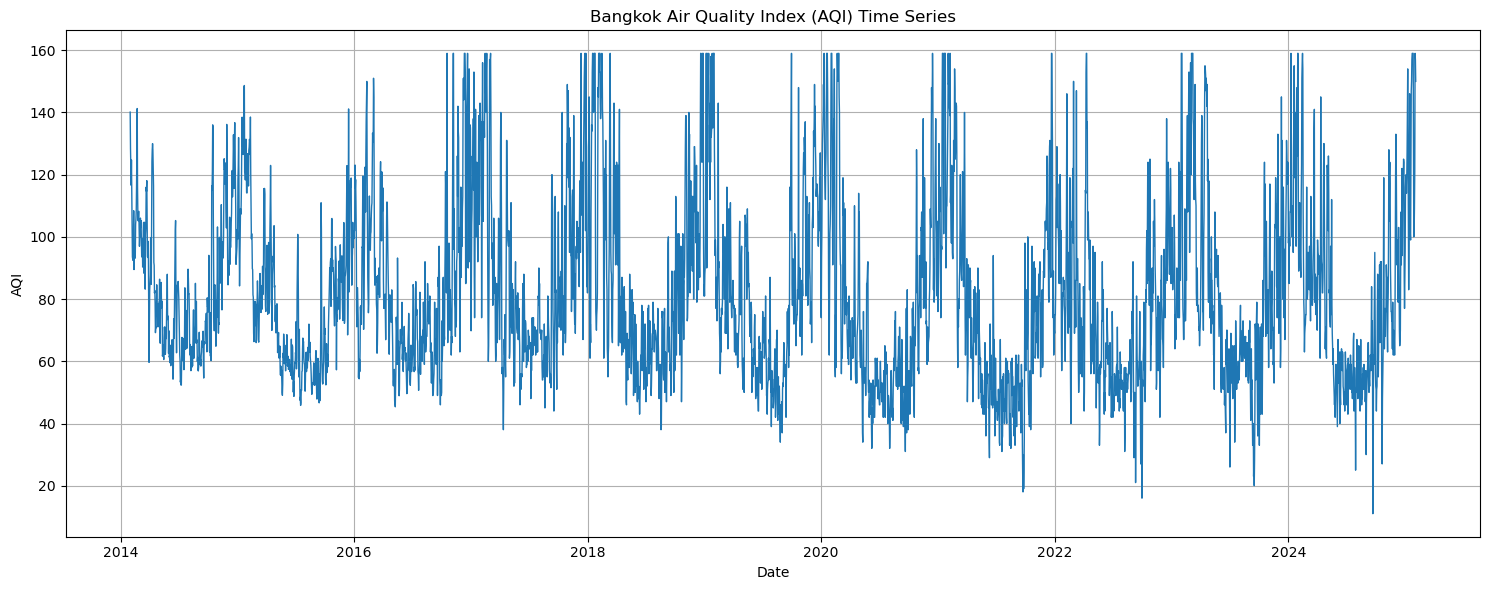

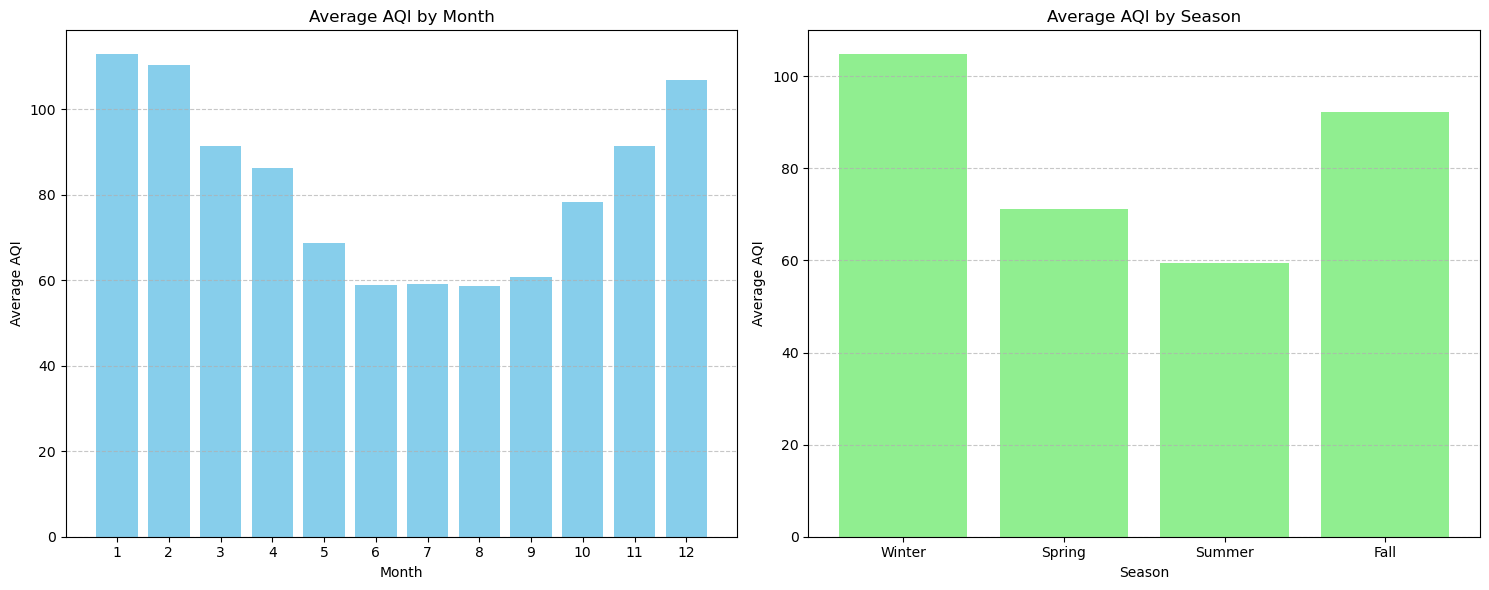

In [4]:
# 3.2 Time series analysis of AQI
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['AQI'], linewidth=1)
plt.title('Bangkok Air Quality Index (AQI) Time Series')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.grid(True)
plt.tight_layout()
plt.savefig('eda_plots/aqi_time_series.png')

# 3.3 Monthly and seasonal patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Monthly patterns
monthly_aqi = df.groupby(df['date'].dt.month)['AQI'].mean()
ax1.bar(monthly_aqi.index, monthly_aqi.values, color='skyblue')
ax1.set_title('Average AQI by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average AQI')
ax1.set_xticks(range(1, 13))
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Seasonal patterns
seasonal_aqi = df.groupby('season')['AQI'].mean()
ax2.bar(seasonal_aqi.index, seasonal_aqi.values, color='lightgreen')
ax2.set_title('Average AQI by Season')
ax2.set_xlabel('Season')
ax2.set_ylabel('Average AQI')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('eda_plots/aqi_seasonal_patterns.png')


Features most correlated with AQI:
AQI              1.000000
pm25             0.999739
pm25_humidity    0.921041
pm10_lag1        0.897688
next_day_AQI     0.876512
                   ...   
humidity_lag1   -0.512684
dew             -0.567292
temp_humidity   -0.570579
dew_lag3        -0.586559
dew_lag1        -0.617424
Name: AQI, Length: 120, dtype: float64


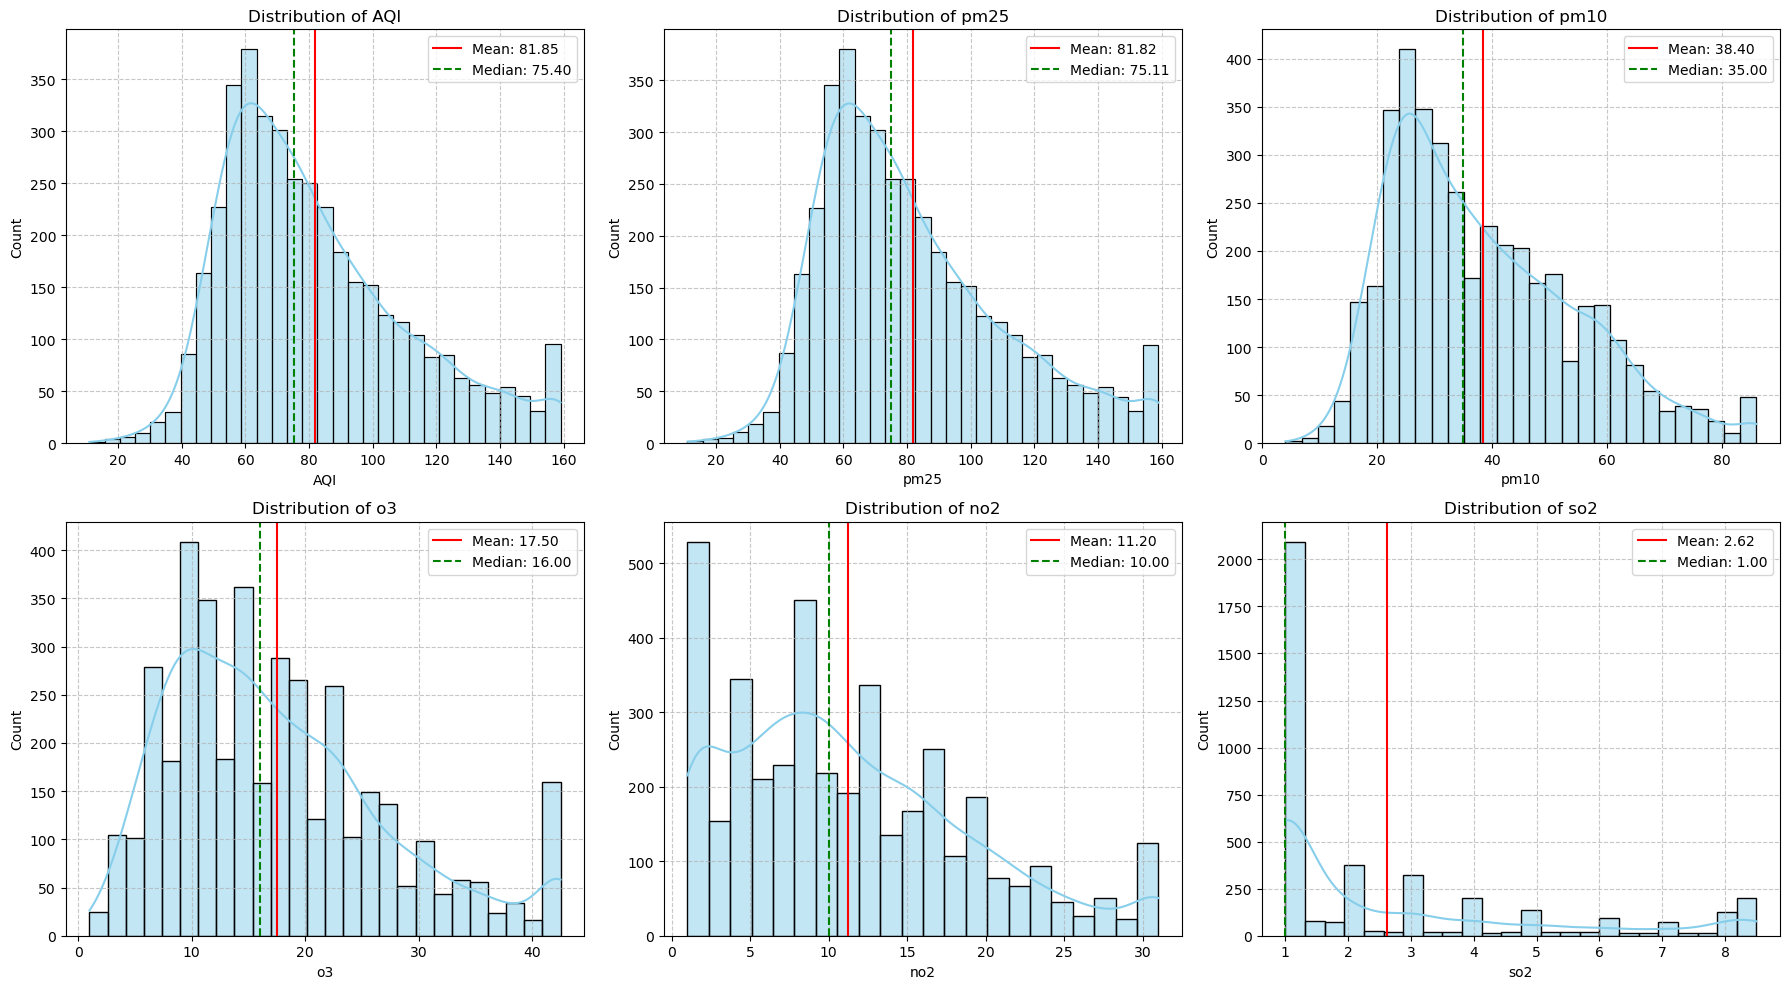

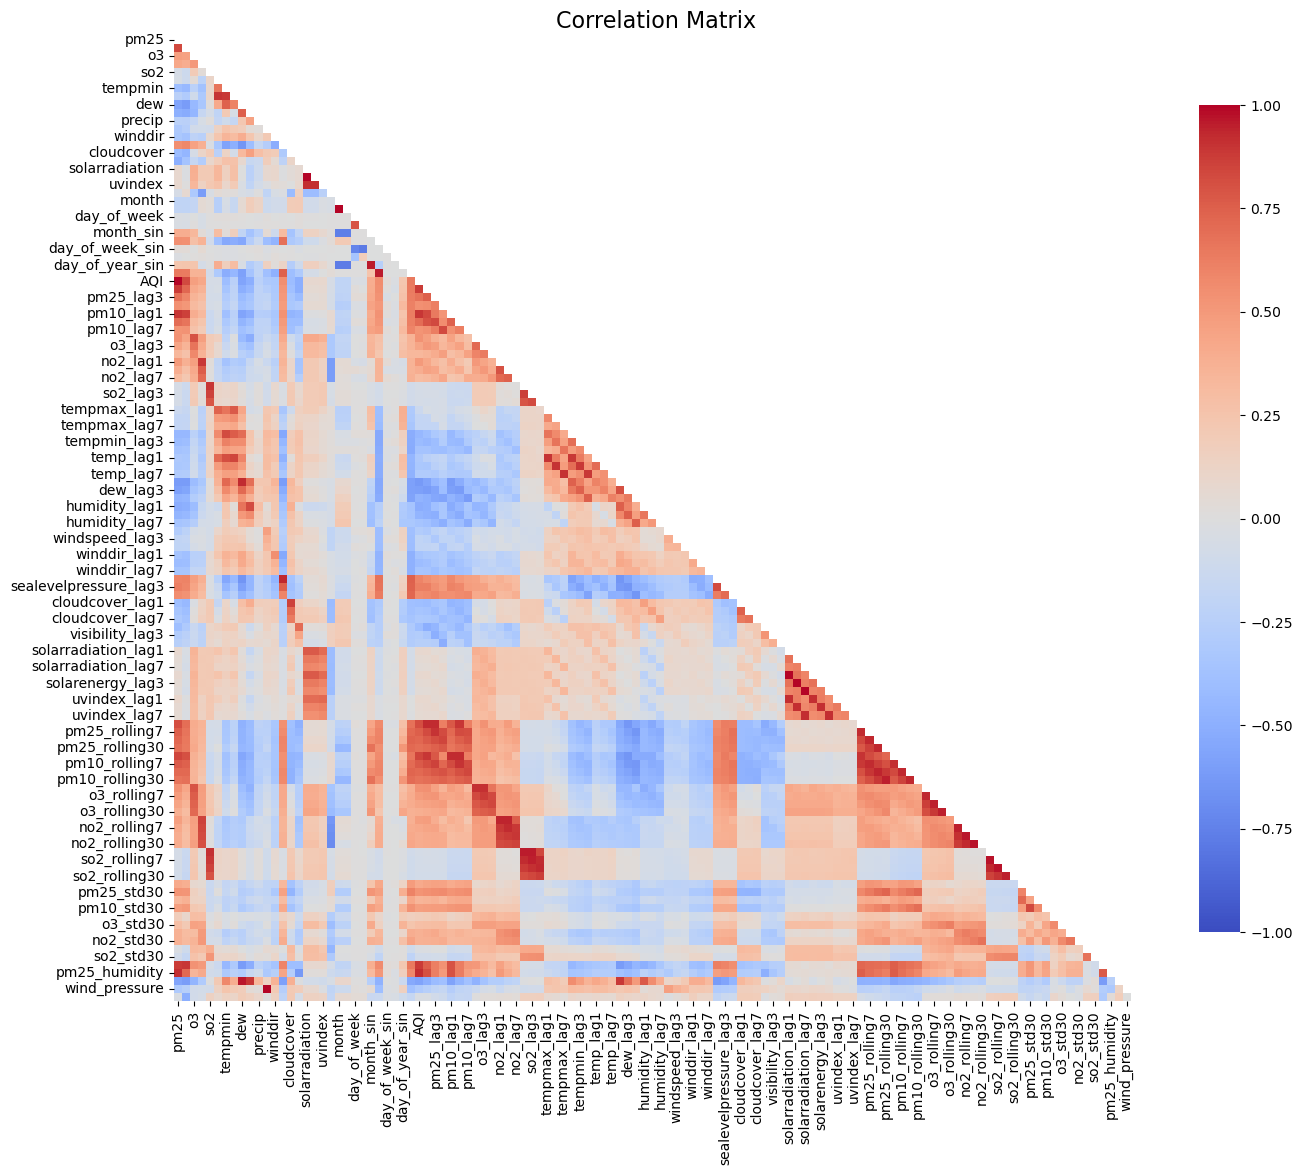

In [5]:
# 3.4 Distribution of AQI and key pollutants
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(['AQI', 'pm25', 'pm10', 'o3', 'no2', 'so2']):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add mean and median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='-', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.savefig('eda_plots/pollutant_distributions.png')

# 3.5 Correlation analysis with heatmap
# Calculate correlation matrix
correlation_matrix = df.select_dtypes(include=[np.number]).corr()

# Sort correlations with AQI
aqi_correlations = correlation_matrix['AQI'].sort_values(ascending=False)
print("\nFeatures most correlated with AQI:")
print(aqi_correlations)

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=False, 
            cmap='coolwarm',
            vmin=-1, vmax=1,
            square=True, 
            cbar_kws={"shrink": .8})

plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.savefig('eda_plots/correlation_heatmap.png')

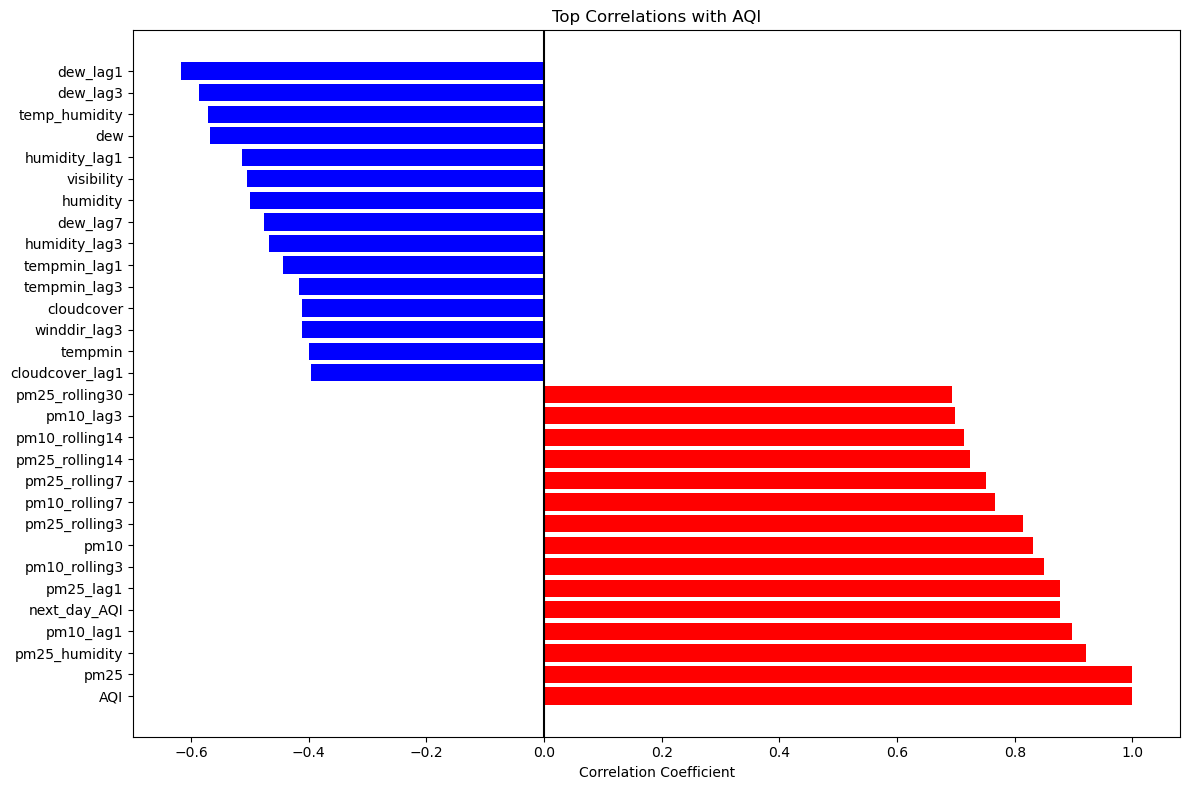

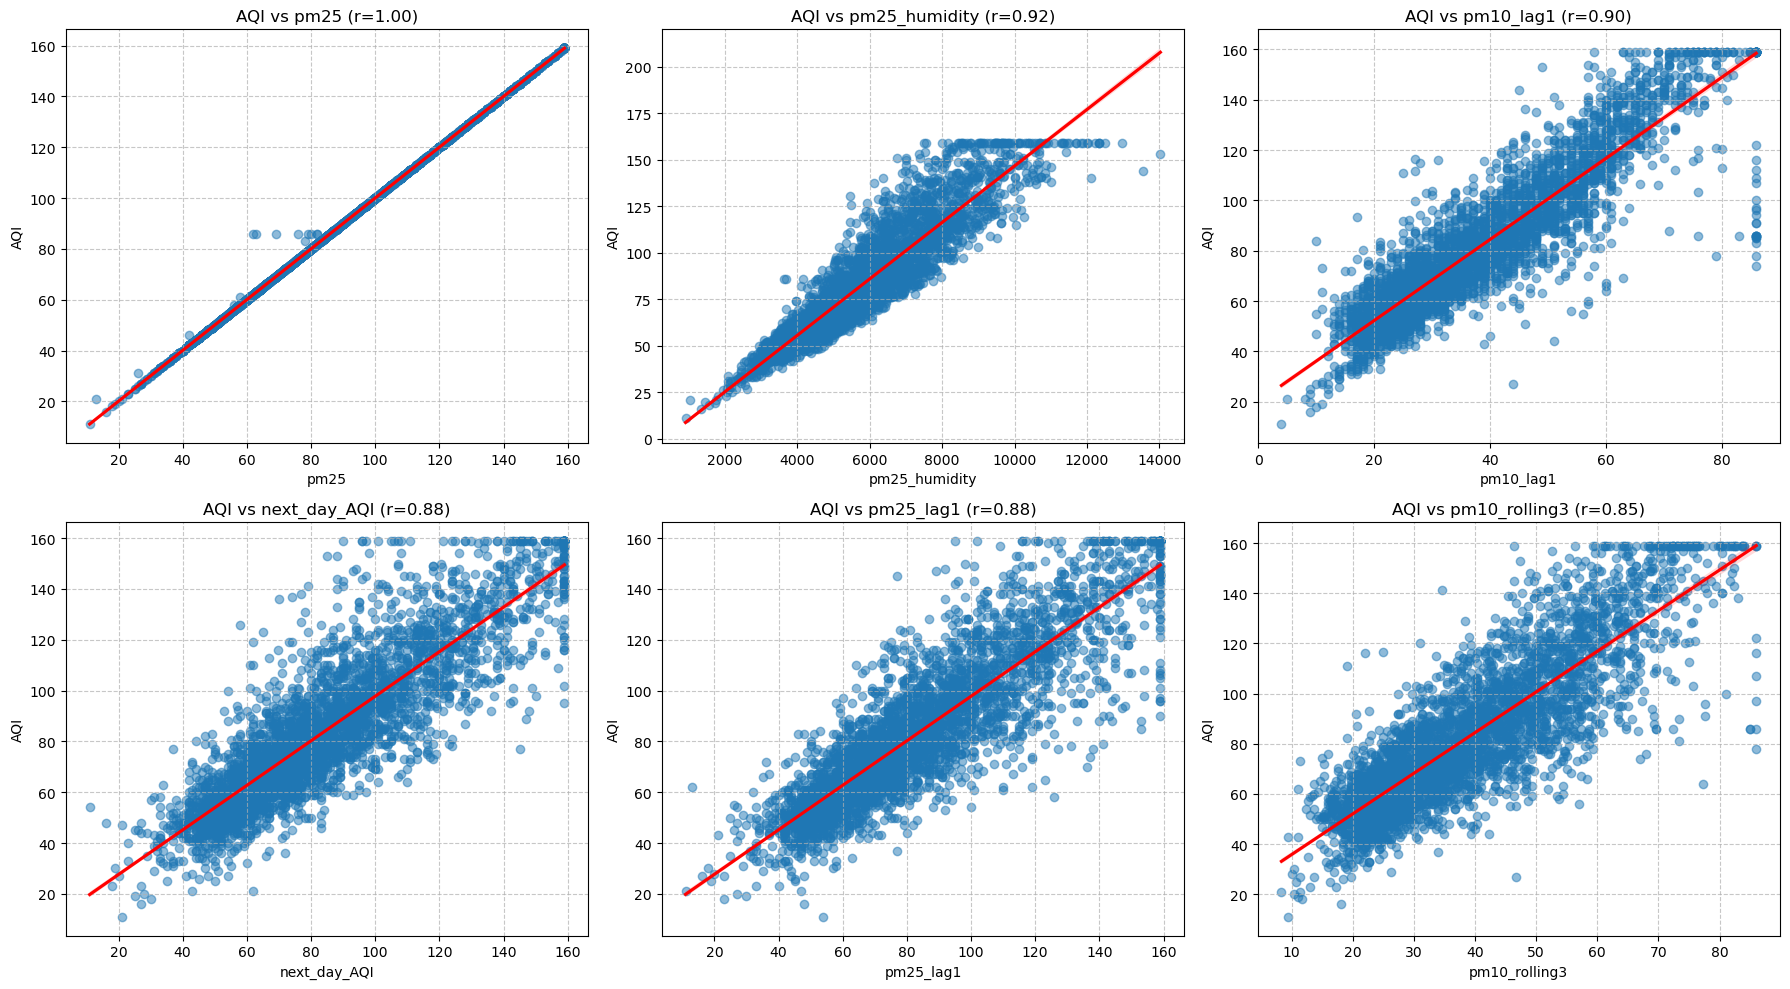

In [6]:
# 3.6 Top correlations with AQI
plt.figure(figsize=(12, 8))
top_correlations = aqi_correlations[:15]  # Top 15 positive correlations
bottom_correlations = aqi_correlations[-15:]  # Top 15 negative correlations
all_top_correlations = pd.concat([top_correlations, bottom_correlations])

# Plot horizontal bar chart
bars = plt.barh(all_top_correlations.index, all_top_correlations.values, color=['red' if x > 0 else 'blue' for x in all_top_correlations.values])
plt.axvline(x=0, color='black', linestyle='-')
plt.title('Top Correlations with AQI')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.savefig('eda_plots/top_aqi_correlations.png')

# 3.7 Scatter plots of AQI vs top correlated features
top_features = aqi_correlations[1:7].index.tolist()  # Skip AQI itself
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.regplot(x=df[feature], y=df['AQI'], ax=axes[i], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    axes[i].set_title(f'AQI vs {feature} (r={correlation_matrix.loc["AQI", feature]:.2f})')
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('eda_plots/aqi_scatter_plots.png')


Augmented Dickey-Fuller Test for AQI:
ADF Statistic: -5.1699
p-value: 0.0000
Critical Values: {'1%': -3.4319850573119437, '5%': -2.8622624788783146, '10%': -2.567154583183171}
Result: The series is stationary (reject H0)


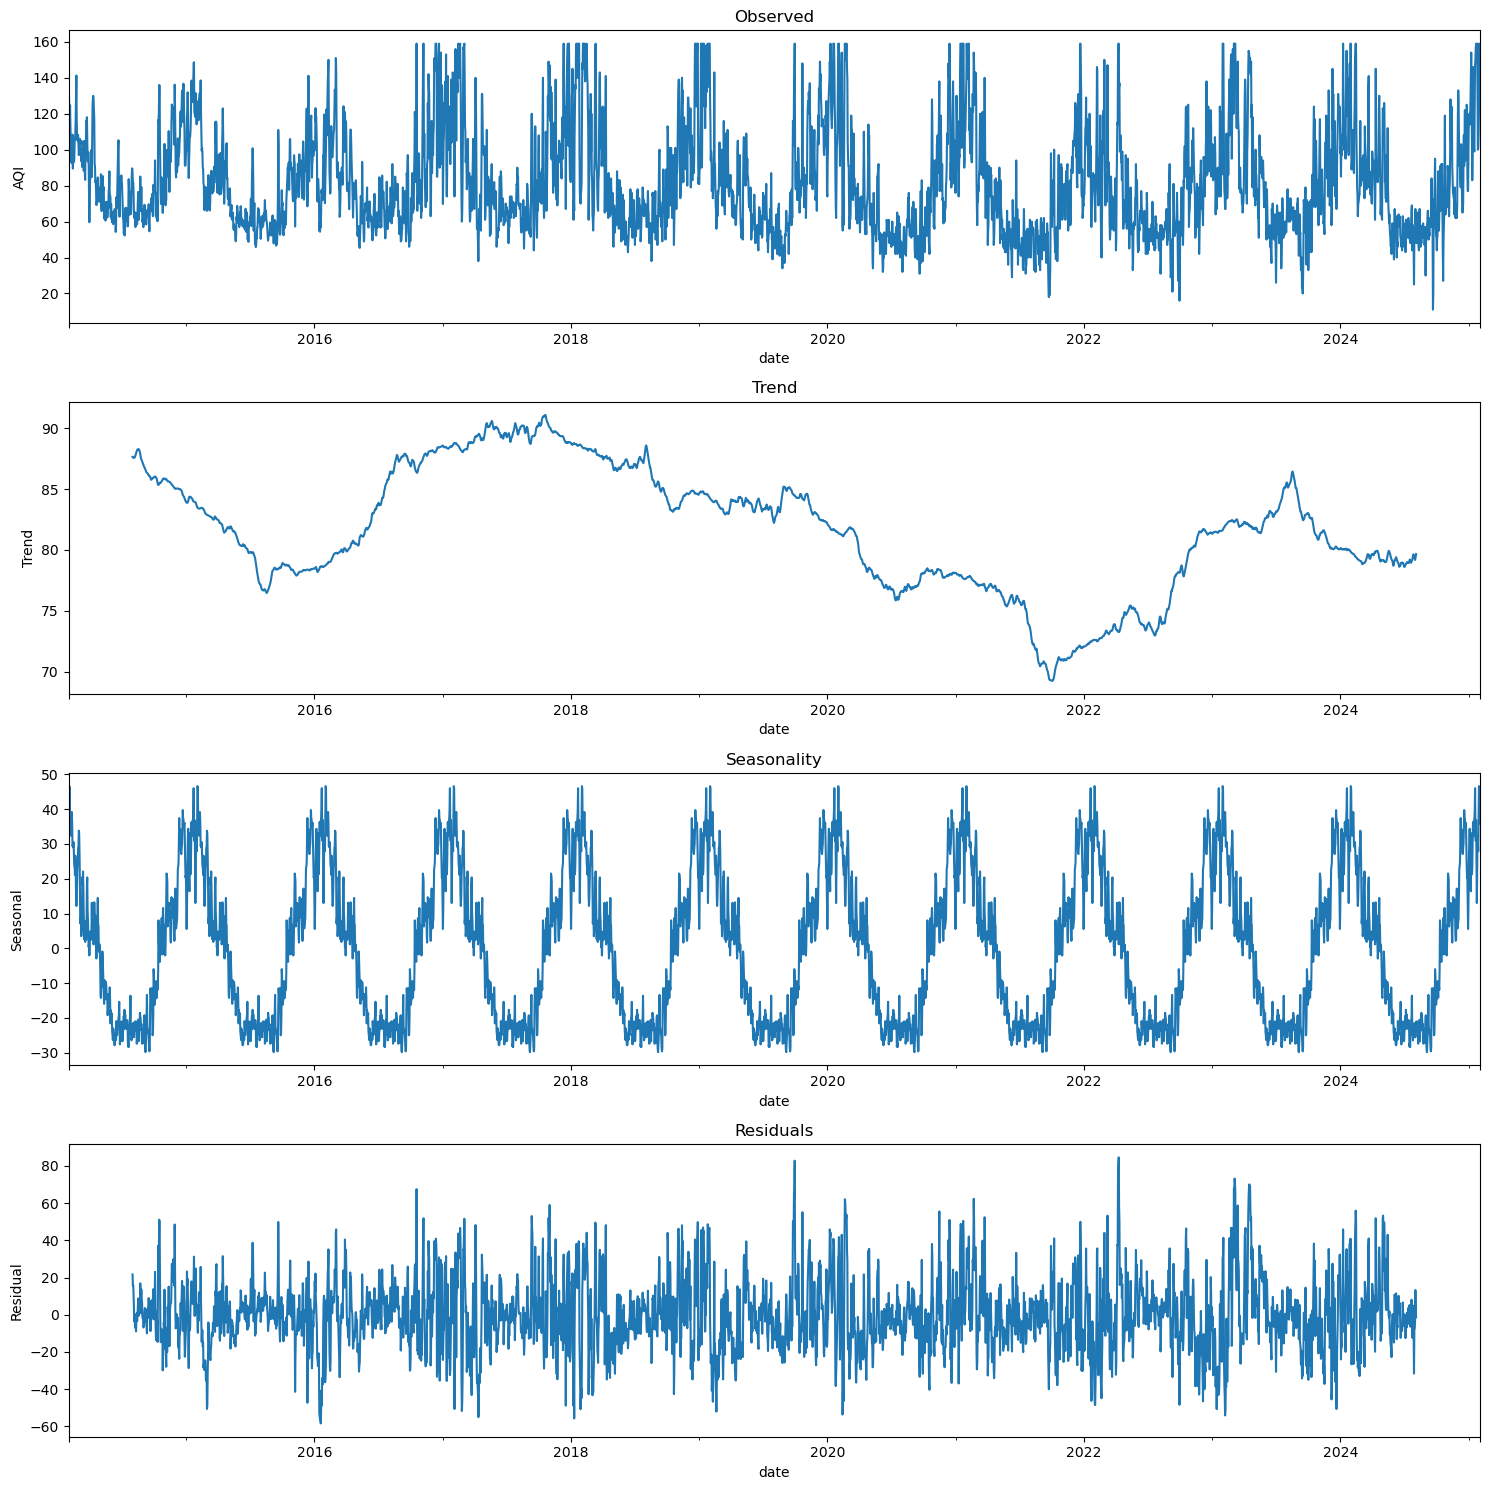

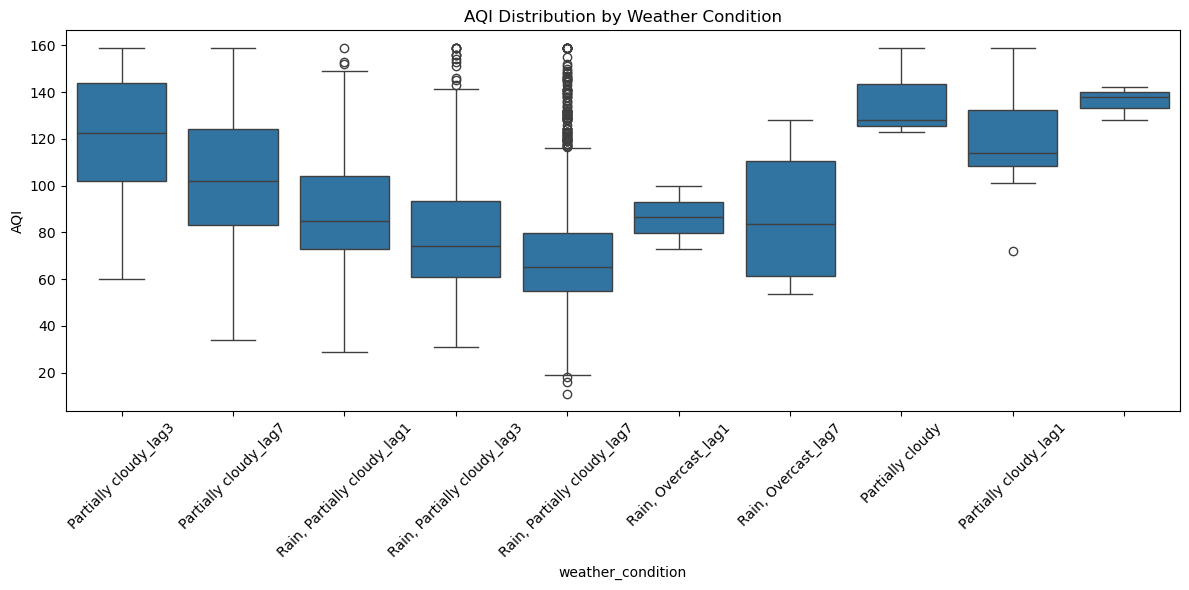

In [7]:
# 3.8 Time series decomposition
if len(df) > 365:  # Need sufficient data for decomposition
    # Resample to daily data if there are multiple entries per day
    aqi_ts = df.set_index('date')['AQI'].resample('D').mean()
    
    # Fill any missing values in the resampled series
    aqi_ts = aqi_ts.fillna(method='ffill')
    
    # Perform time series decomposition
    decomposition = seasonal_decompose(aqi_ts, model='additive', period=365)
    
    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 15))
    
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    ax1.set_ylabel('AQI')
    
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    ax2.set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonality')
    ax3.set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residuals')
    ax4.set_ylabel('Residual')
    
    plt.tight_layout()
    plt.savefig('eda_plots/aqi_decomposition.png')
    
    # Perform Augmented Dickey-Fuller test to check stationarity
    result = adfuller(aqi_ts.dropna())
    print('\nAugmented Dickey-Fuller Test for AQI:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values: {result[4]}')
    if result[1] <= 0.05:
        print("Result: The series is stationary (reject H0)")
    else:
        print("Result: The series is non-stationary (fail to reject H0)")

# 3.9 Weather conditions impact on AQI
if any(col.startswith('conditions_') for col in df.columns):
    condition_cols = [col for col in df.columns if col.startswith('conditions_')]
    
    # Create a new column with the actual condition name
    df['weather_condition'] = ''
    for col in condition_cols:
        condition_name = col.replace('conditions_', '')
        df.loc[df[col] == 1, 'weather_condition'] = condition_name
    
    # Plot AQI by weather condition
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='weather_condition', y='AQI', data=df)
    plt.title('AQI Distribution by Weather Condition')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('eda_plots/aqi_by_weather.png')


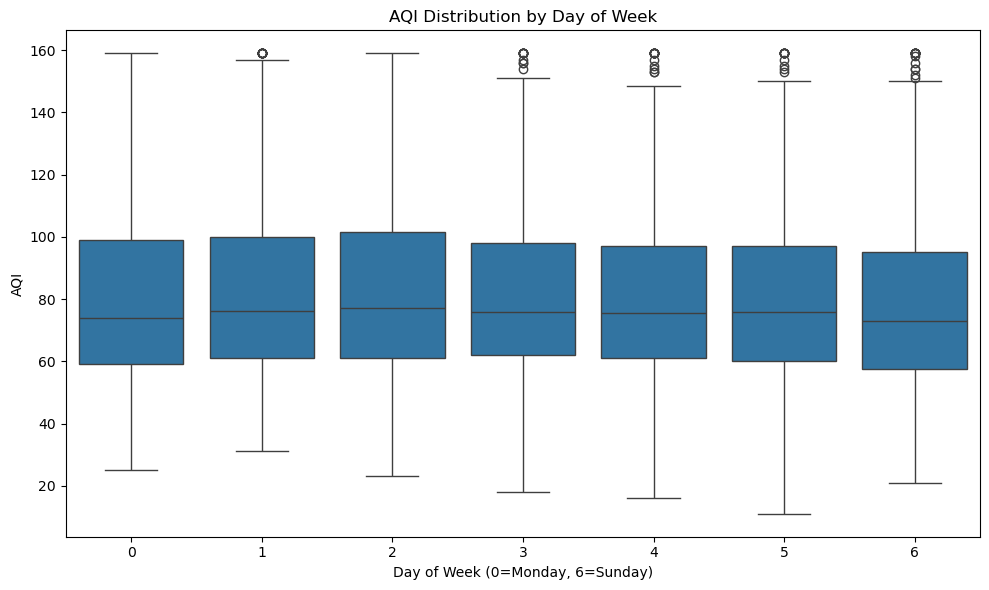

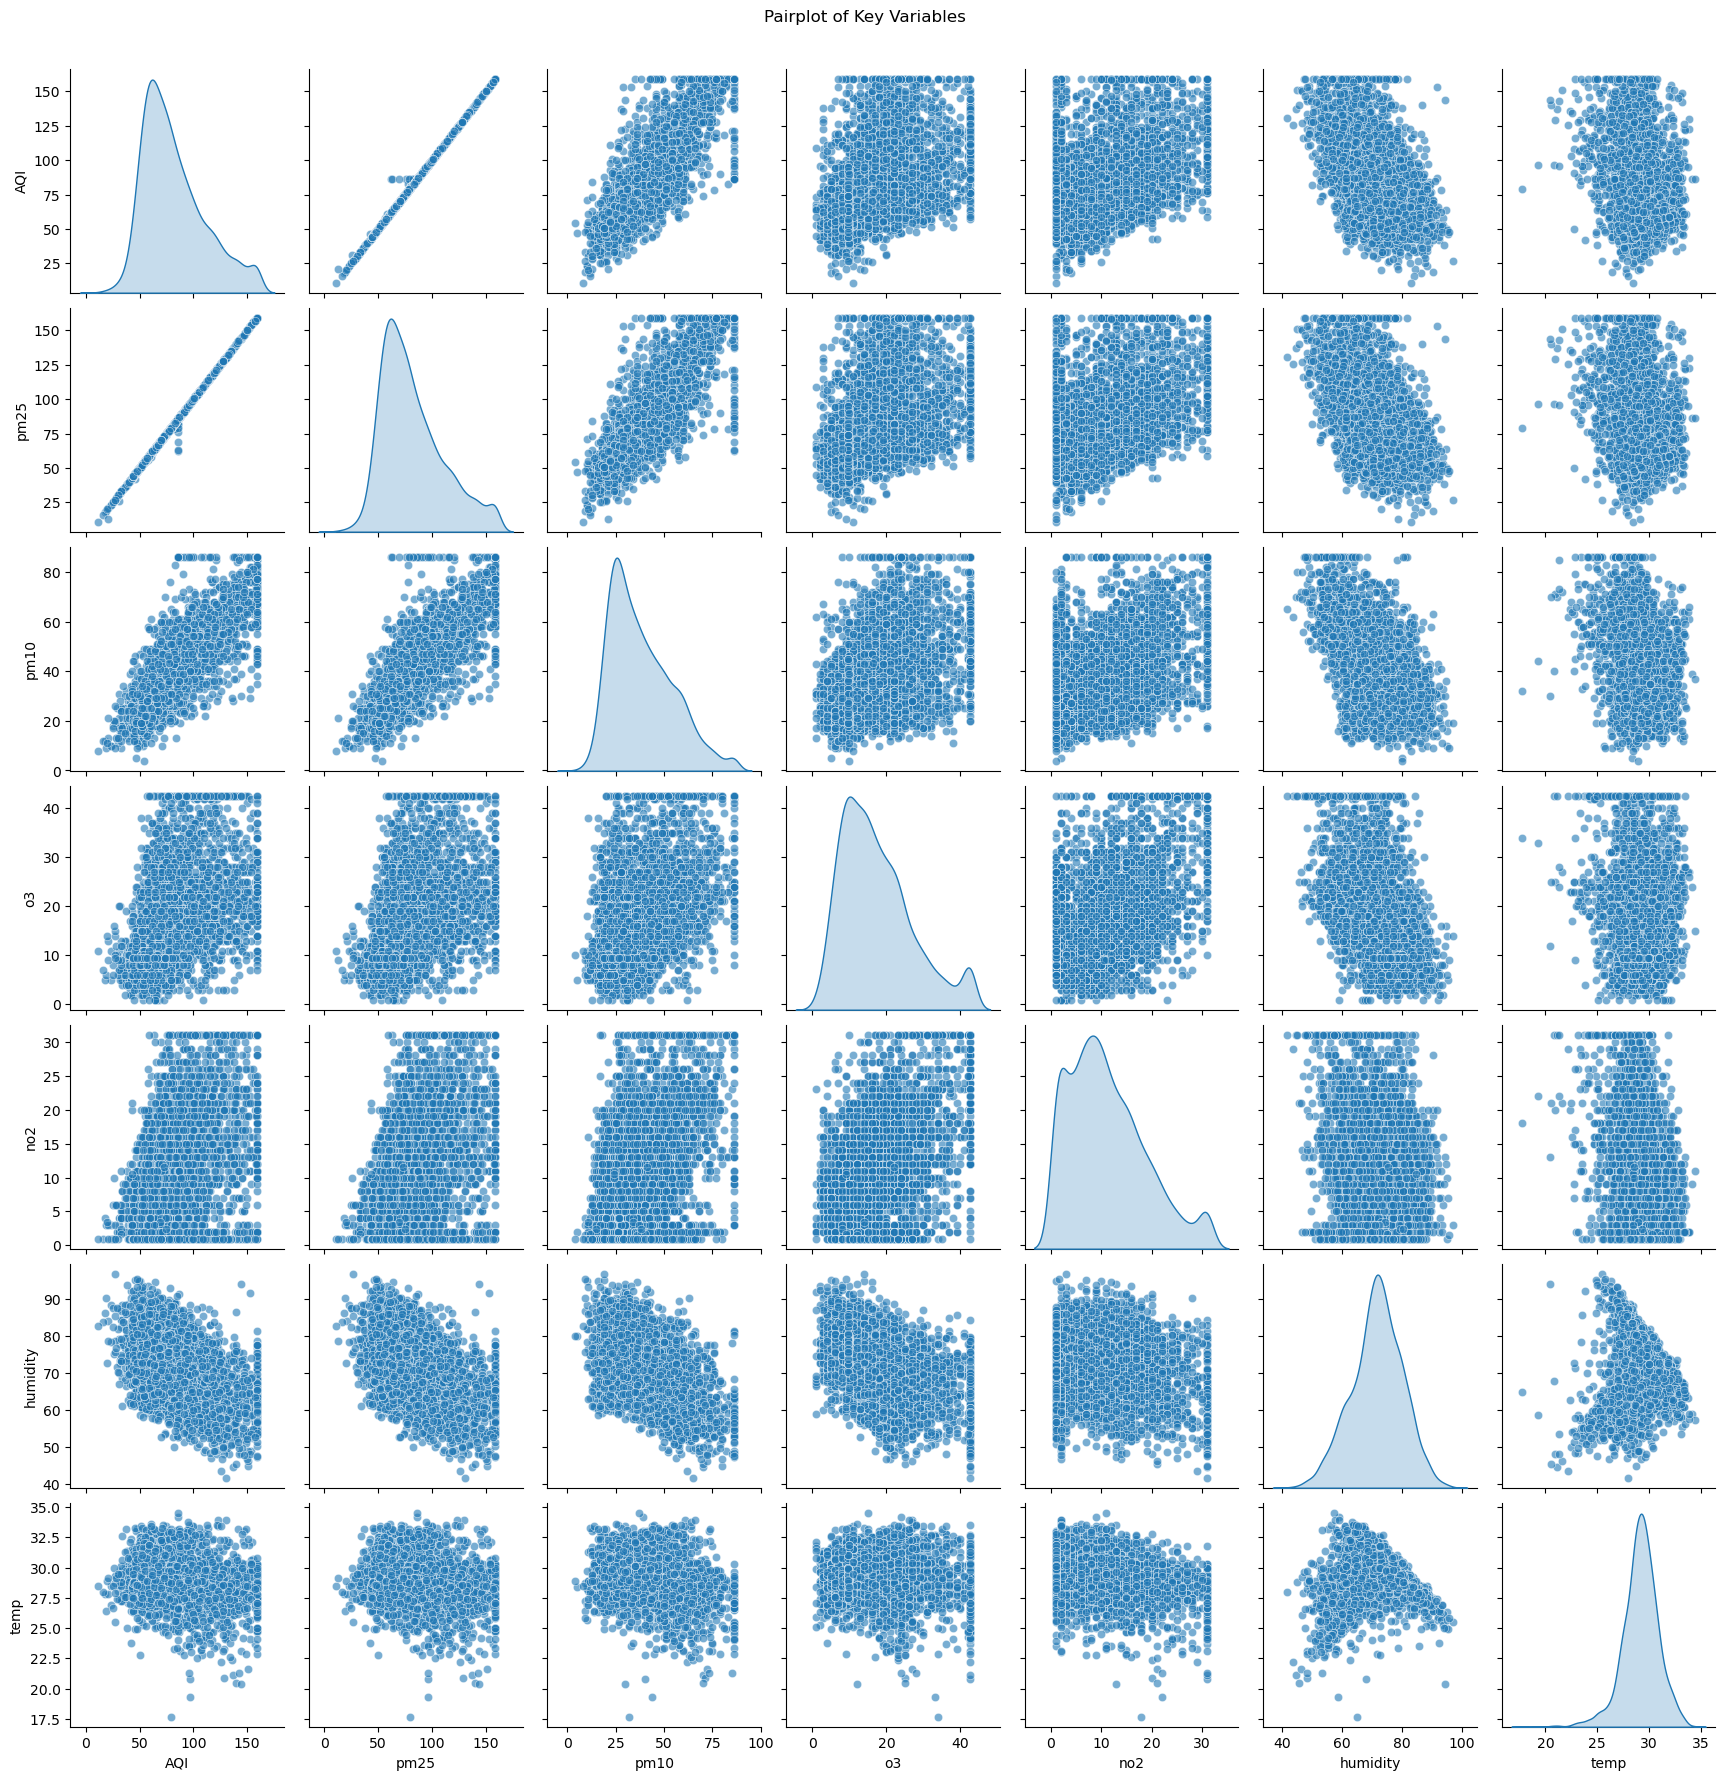

In [8]:
# 3.10 Weekday vs Weekend AQI patterns
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='AQI', data=df)
plt.title('AQI Distribution by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.tight_layout()
plt.savefig('eda_plots/aqi_by_day.png')

# 3.11 Pairplot of key variables
key_vars = ['AQI', 'pm25', 'pm10', 'o3', 'no2', 'humidity', 'temp']
sns.pairplot(df[key_vars], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Key Variables', y=1.02)
plt.savefig('eda_plots/key_vars_pairplot.png')


Top 15 features by importance:
             Feature  Importance
0               pm25    0.999488
1               pm10    0.000378
8                dew    0.000037
12  sealevelpressure    0.000030
6            tempmin    0.000019
9           humidity    0.000012
13        cloudcover    0.000008
7               temp    0.000006
4                so2    0.000004
5            tempmax    0.000004
11           winddir    0.000003
2                 o3    0.000002
15    solarradiation    0.000002
14        visibility    0.000002
10         windspeed    0.000002

EDA completed. Plots saved to 'eda_plots' directory.


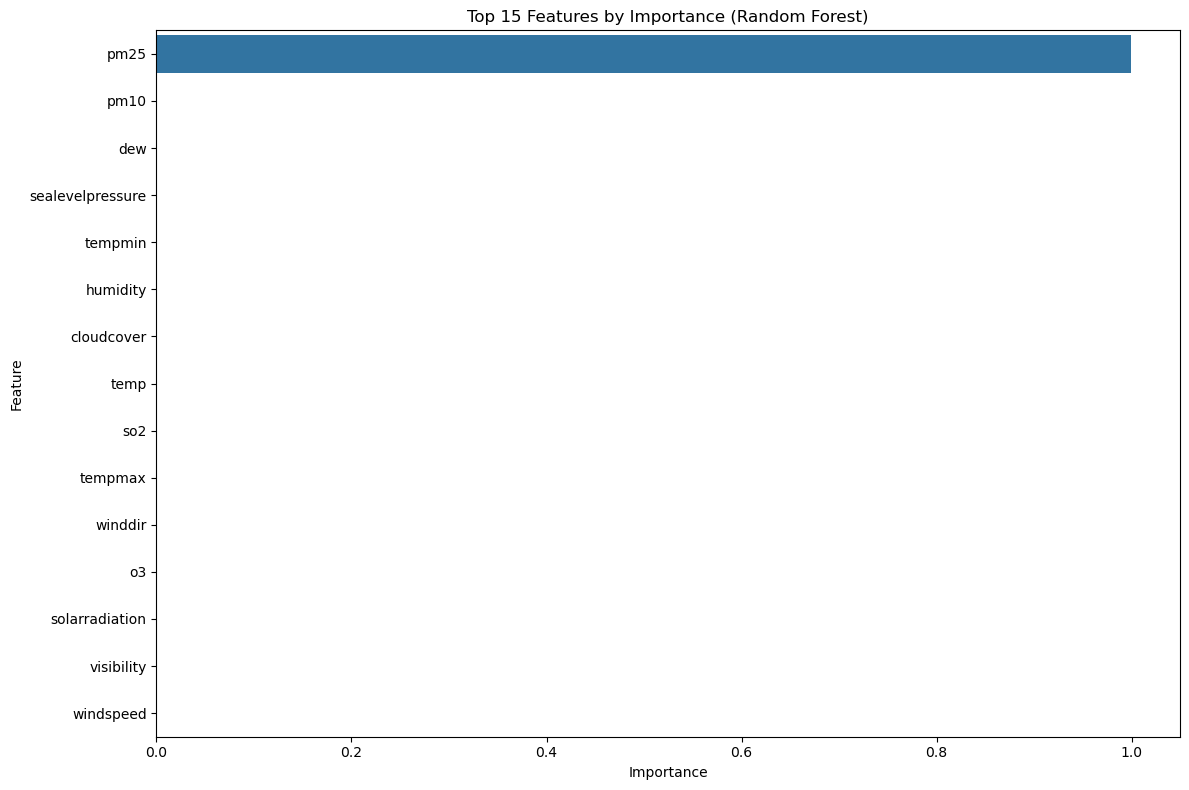

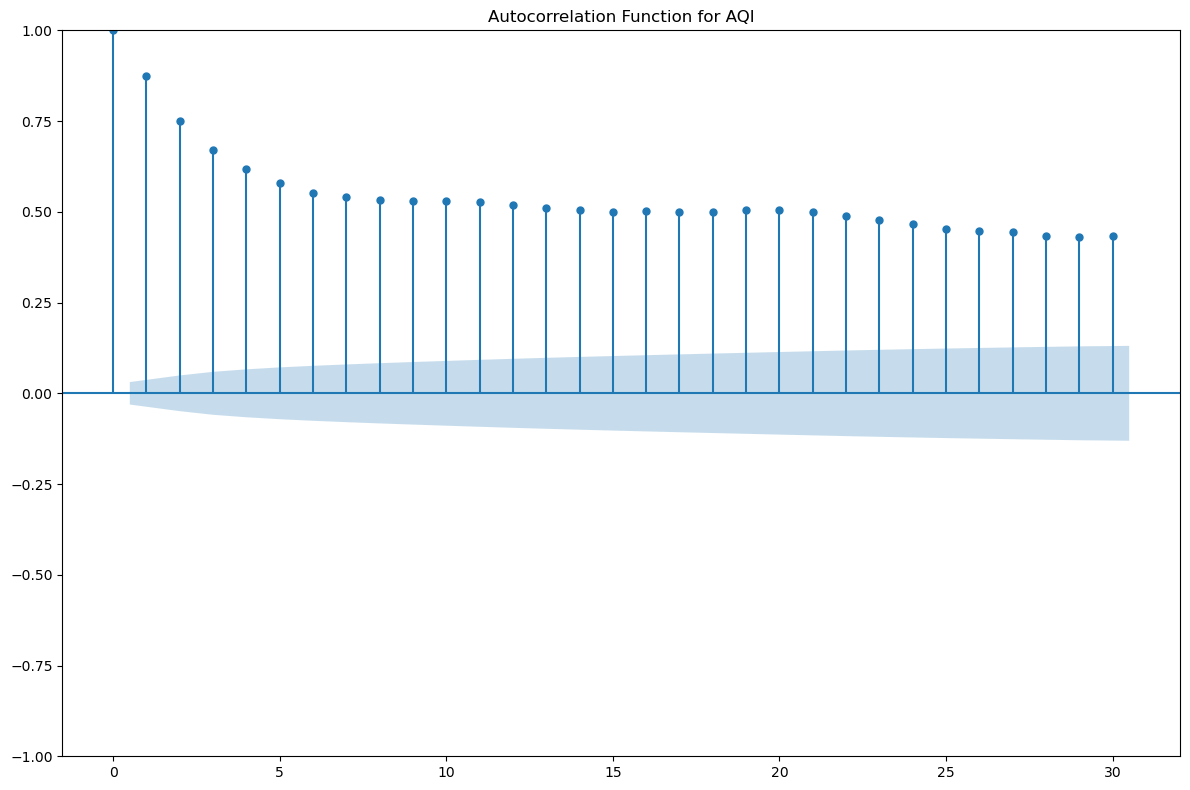

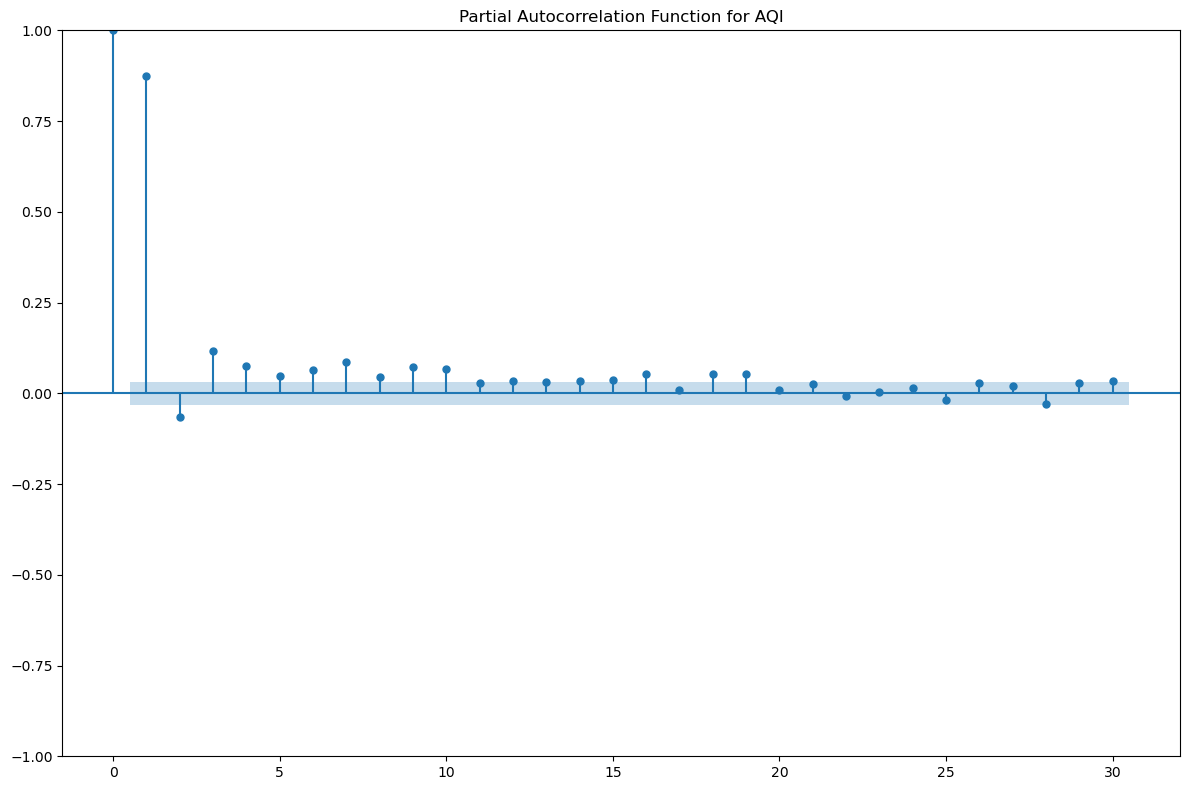

In [9]:
# 3.12 Feature importance using Random Forest
X = df[lag_columns]
y = df['AQI']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Importance (Random Forest)')
plt.tight_layout()
plt.savefig('eda_plots/feature_importance.png')

print("\nTop 15 features by importance:")
print(feature_importance.head(15))

# 3.13 Autocorrelation and Partial Autocorrelation analysis
plt.figure(figsize=(12, 8))
plot_acf(df['AQI'], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function for AQI')
plt.tight_layout()
plt.savefig('eda_plots/aqi_acf.png')

plt.figure(figsize=(12, 8))
plot_pacf(df['AQI'], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function for AQI')
plt.tight_layout()
plt.savefig('eda_plots/aqi_pacf.png')

print("\nEDA completed. Plots saved to 'eda_plots' directory.")

In [10]:
# ===============================
# 4. Feature Selection and Engineering
# ===============================
print("\n--- Starting Feature Selection and Engineering ---")

# 4.1 Select features based on correlation analysis
# Get the top correlated features with AQI (both positive and negative)
aqi_corr = correlation_matrix['AQI'].abs().sort_values(ascending=False)
top_correlated = aqi_corr[1:16].index.tolist()  # Skip AQI itself, get top 15

print("\nTop 15 features by absolute correlation with AQI:")
for feature in top_correlated:
    print(f"{feature}: {correlation_matrix['AQI'][feature]:.4f}")

# 4.2 Feature selection using SelectKBest
X = df.drop(['AQI', 'next_day_AQI', 'date', 'season', 'weather_condition'], axis=1, errors='ignore')
X = X.select_dtypes(include=[np.number])  # Keep only numeric columns
y = df['next_day_AQI']

# Apply SelectKBest with f_regression
selector_f = SelectKBest(score_func=f_regression, k=20)
X_new_f = selector_f.fit_transform(X, y)
selected_features_f = X.columns[selector_f.get_support()]

print("\nTop 20 features selected by f_regression:")
scores_f = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_f.scores_
}).sort_values('Score', ascending=False)
print(scores_f.head(20))

# Apply SelectKBest with mutual_info_regression
selector_mi = SelectKBest(score_func=mutual_info_regression, k=20)
X_new_mi = selector_mi.fit_transform(X, y)
selected_features_mi = X.columns[selector_mi.get_support()]

print("\nTop 20 features selected by mutual_info_regression:")
scores_mi = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_mi.scores_
}).sort_values('Score', ascending=False)
print(scores_mi.head(20))


--- Starting Feature Selection and Engineering ---

Top 15 features by absolute correlation with AQI:
pm25: 0.9997
pm25_humidity: 0.9210
pm10_lag1: 0.8977
next_day_AQI: 0.8765
pm25_lag1: 0.8761
pm10_rolling3: 0.8496
pm10: 0.8311
pm25_rolling3: 0.8132
pm10_rolling7: 0.7673
pm25_rolling7: 0.7515
pm25_rolling14: 0.7233
pm10_rolling14: 0.7143
pm10_lag3: 0.6988
pm25_rolling30: 0.6933
pm25_lag3: 0.6727

Top 20 features selected by f_regression:
                   Feature         Score
1                     pm10  16640.475521
0                     pm25  13242.585645
33               pm10_lag1   7112.794893
114          pm25_humidity   5790.760775
88           pm10_rolling3   5315.380652
30               pm25_lag1   5238.125332
84           pm25_rolling3   4401.472558
89           pm10_rolling7   3931.153894
85           pm25_rolling7   3769.395423
86          pm25_rolling14   3665.632537
90          pm10_rolling14   3387.612158
87          pm25_rolling30   3349.593975
91          pm10_rollin


Top features selected by Random Forest importance:
1. pm10 (Importance: 0.7861)
2. pm25 (Importance: 0.0866)
3. pm25_pm10_ratio (Importance: 0.0134)
4. no2 (Importance: 0.0074)
5. year (Importance: 0.0045)
6. o3 (Importance: 0.0040)
7. pm10_lag1 (Importance: 0.0033)
8. o3_rolling30 (Importance: 0.0022)
9. no2_rolling30 (Importance: 0.0019)
10. o3_rolling3 (Importance: 0.0019)
11. winddir (Importance: 0.0018)
12. day_of_year_cos (Importance: 0.0018)
13. pm25_humidity (Importance: 0.0016)
14. pm10_std30 (Importance: 0.0016)
15. pm10_rolling3 (Importance: 0.0015)
16. o3_rolling7 (Importance: 0.0015)
17. pm25_rolling30 (Importance: 0.0014)
18. sealevelpressure (Importance: 0.0014)
19. winddir_lag3 (Importance: 0.0014)
20. pm25_std7 (Importance: 0.0013)

Final selected features (appearing in at least 2 selection methods):
pm25
pm25_humidity
pm10_lag1
pm25_lag1
pm10_rolling3
pm10
pm25_rolling3
pm10_rolling7
pm25_rolling7
pm25_rolling14
pm10_rolling14
pm10_lag3
pm25_rolling30
pm25_lag3
day_o

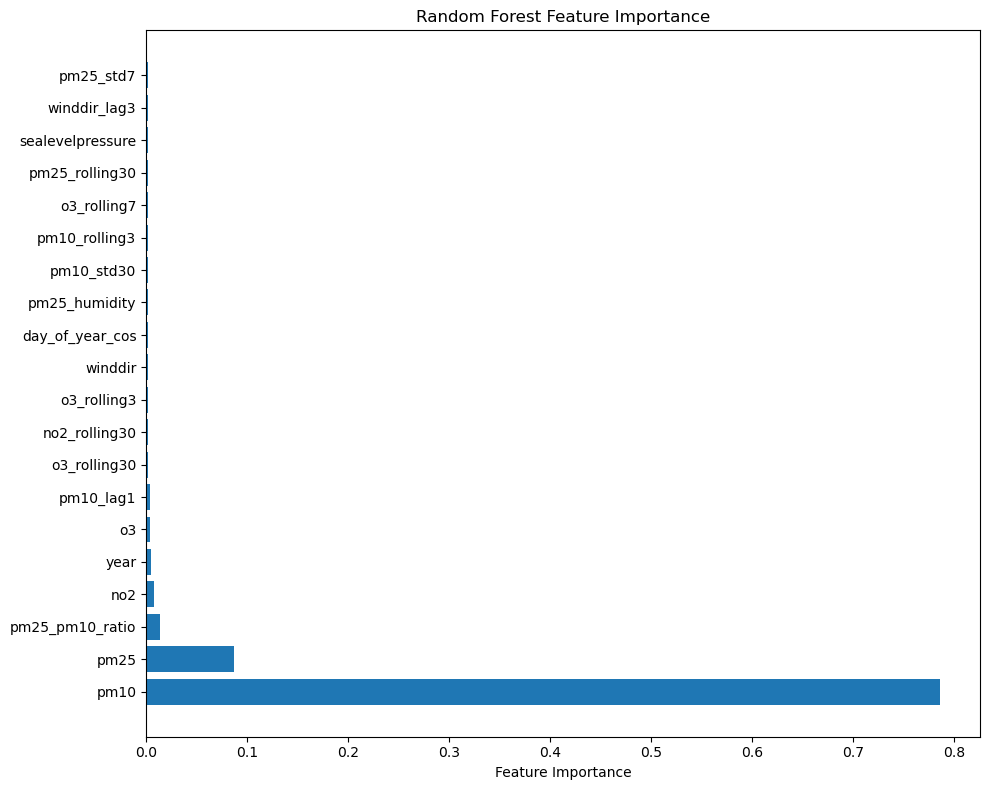

In [11]:
# Alternative approach without using RFE/RFECV
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances directly from Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top 20 features
top_rf_features = [X.columns[i] for i in indices[:20]]

print("\nTop features selected by Random Forest importance:")
for i, feature in enumerate(top_rf_features):
    print(f"{i+1}. {feature} (Importance: {importances[indices[i]]:.4f})")

# Visualize feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(20), importances[indices[:20]], align='center')
plt.yticks(range(20), [X.columns[i] for i in indices[:20]])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('eda_plots/rf_importance.png')

# 4.4 Combine feature selection methods
# Get features that appear in at least 2 of the 4 methods
all_selected_features = []
all_selected_features.extend(top_correlated)
all_selected_features.extend(selected_features_f)
all_selected_features.extend(selected_features_mi)
all_selected_features.extend(top_rf_features)  # Use RF features instead of RFE

# Count occurrences of each feature
from collections import Counter
feature_counts = Counter(all_selected_features)

# Select features that appear in at least 2 methods
final_features = [feature for feature, count in feature_counts.items() if count >= 2]

print("\nFinal selected features (appearing in at least 2 selection methods):")
for feature in final_features:
    print(feature)

# Add lag1 of AQI to final features (strong predictor for next day)
if 'AQI_lag1' not in final_features and 'AQI_lag1' in df.columns:
    final_features.append('AQI_lag1')
    print("Added AQI_lag1 to final features")


In [12]:
# ===============================
# 5. Model Preparation
# ===============================
print("\n--- Preparing Data for Modeling ---")

# Prepare final dataset with selected features
X = df[final_features]
y = df['next_day_AQI']

# Split data for training and testing
# Use time-based split for time series data
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



--- Preparing Data for Modeling ---
Training set: 3210 samples
Testing set: 803 samples


In [13]:
# ===============================
# 6. Model Building and Evaluation
# ===============================
print("\n--- Building and Evaluating Models ---")

# Create a directory for model results
os.makedirs('model_results', exist_ok=True)

# Function to evaluate and record model performance
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape*100:.2f}%")
    print(f"R²: {r2:.4f}")
    print(f"Explained Variance: {evs:.4f}")
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Explained Variance': evs
    }

# Dictionary to store all model results
all_model_results = []


--- Building and Evaluating Models ---


In [14]:
# ===============================
# 6.1 Linear Models
# ===============================

# 6.1.1 Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
lr_results = evaluate_model("Linear Regression", y_test, y_pred_lr)
all_model_results.append(lr_results)

# 6.1.2 Ridge Regression with CV
ridge_cv = Ridge(random_state=42)
alphas = np.logspace(-6, 6, 13)
ridge_cv_params = {'alpha': alphas}
ridge_cv_grid = GridSearchCV(ridge_cv, ridge_cv_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
ridge_cv_grid.fit(X_train_scaled, y_train)
print(f"Best Ridge alpha: {ridge_cv_grid.best_params_['alpha']}")
y_pred_ridge = ridge_cv_grid.predict(X_test_scaled)
ridge_results = evaluate_model("Ridge Regression", y_test, y_pred_ridge)
all_model_results.append(ridge_results)

# 6.1.3 Lasso Regression with CV
lasso_cv = Lasso(random_state=42, max_iter=10000)
lasso_cv_params = {'alpha': alphas}
lasso_cv_grid = GridSearchCV(lasso_cv, lasso_cv_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
lasso_cv_grid.fit(X_train_scaled, y_train)
print(f"Best Lasso alpha: {lasso_cv_grid.best_params_['alpha']}")
y_pred_lasso = lasso_cv_grid.predict(X_test_scaled)
lasso_results = evaluate_model("Lasso Regression", y_test, y_pred_lasso)
all_model_results.append(lasso_results)

# 6.1.4 ElasticNet with CV
elasticnet_cv = ElasticNet(random_state=42, max_iter=10000)
elasticnet_cv_params = {
    'alpha': alphas,
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elasticnet_cv_grid = GridSearchCV(elasticnet_cv, elasticnet_cv_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
elasticnet_cv_grid.fit(X_train_scaled, y_train)
print(f"Best ElasticNet parameters: {elasticnet_cv_grid.best_params_}")
y_pred_elasticnet = elasticnet_cv_grid.predict(X_test_scaled)
elasticnet_results = evaluate_model("ElasticNet", y_test, y_pred_elasticnet)
all_model_results.append(elasticnet_results)



Linear Regression Performance:
MSE: 178.6144
RMSE: 13.3647
MAE: 9.3918
MAPE: 11.80%
R²: 0.8031
Explained Variance: 0.8072
Best Ridge alpha: 10.0

Ridge Regression Performance:
MSE: 176.8143
RMSE: 13.2972
MAE: 9.3841
MAPE: 11.77%
R²: 0.8051
Explained Variance: 0.8096
Best Lasso alpha: 0.1

Lasso Regression Performance:
MSE: 179.5372
RMSE: 13.3991
MAE: 9.4819
MAPE: 11.82%
R²: 0.8021
Explained Variance: 0.8069
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}

ElasticNet Performance:
MSE: 176.7887
RMSE: 13.2962
MAE: 9.4234
MAPE: 11.79%
R²: 0.8051
Explained Variance: 0.8102


In [15]:
# ===============================
# 6.2 Tree-Based Models
# ===============================
from scipy.stats import randint, uniform, loguniform
rf_params = {
    'n_estimators': randint(50, 500),  # Expanded range
    'max_depth': [None, 5, 10, 20, 30, 40, 50],  # Added finer options
    'min_samples_split': randint(2, 30),  # Expanded range
    'min_samples_leaf': randint(1, 20),   # Expanded range
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]  # New parameter
}

rf_model = RandomForestRegressor(random_state=42)

rf_grid = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_params,
    n_iter=40,  # Increased iterations for a broader search
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_grid.fit(X_train_scaled, y_train)
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
y_pred_rf = rf_grid.predict(X_test_scaled)
rf_results = evaluate_model("Random Forest", y_test, y_pred_rf)
all_model_results.append(rf_results)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Random Forest parameters: {'bootstrap': True, 'max_depth': 40, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 274}

Random Forest Performance:
MSE: 218.3246
RMSE: 14.7758
MAE: 9.6035
MAPE: 12.55%
R²: 0.7593
Explained Variance: 0.7599


In [16]:
# 6.2.2 Gradient Boosting with Hyperparameter Tuning
from scipy.stats import randint, uniform, loguniform
gb_params = {
    'n_estimators': randint(300, 1000),  # Increase the number of estimators
    'learning_rate': loguniform(0.005, 0.1),  # Lower learning rate range for better generalization
    'max_depth': randint(4, 10),  # Slightly deeper trees
    'min_samples_split': randint(5, 20),  # More focused range
    'min_samples_leaf': randint(3, 15),  # More focused range
    'subsample': uniform(0.7, 0.3),  # Higher subsample values (0.7-1.0)
    'max_features': uniform(0.6, 0.4)  # Focus on higher feature fractions
}

gb_model = GradientBoostingRegressor(
    random_state=42,
    validation_fraction=0.2,  # Add validation fraction
    n_iter_no_change=20,  # Early stopping
    tol=0.001  # Tolerance for early stopping
)

gb_grid = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=gb_params,
    n_iter=50,  # Reduced iterations but more focused search space
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

gb_grid.fit(X_train_scaled, y_train)
print(f"Best Gradient Boosting parameters: {gb_grid.best_params_}")
y_pred_gb = gb_grid.predict(X_test_scaled)
gb_results = evaluate_model("Gradient Boosting", y_test, y_pred_gb)
all_model_results.append(gb_results)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Gradient Boosting parameters: {'learning_rate': 0.04019817887522635, 'max_depth': 7, 'max_features': 0.6699819708383744, 'min_samples_leaf': 11, 'min_samples_split': 8, 'n_estimators': 871, 'subsample': 0.7782487524491226}

Gradient Boosting Performance:
MSE: 161.0490
RMSE: 12.6905
MAE: 8.9822
MAPE: 11.76%
R²: 0.8224
Explained Variance: 0.8232


In [17]:
# 6.2.3 XGBoost with Hyperparameter Tuning
xgb_params = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# Create an XGBRegressor without early_stopping_rounds for hyperparameter tuning
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',  # Enable GPU acceleration if available
    random_state=42
)
# Define a TimeSeriesSplit for cross-validation if your data is sequential.
cv = TimeSeriesSplit(n_splits=5)

# Set up RandomizedSearchCV
xgb_grid = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    n_iter=20,  # Increase this number if you want to explore more combinations
    cv=cv,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

xgb_grid.fit(X_train_scaled, y_train)
print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
y_pred_xgb = xgb_grid.predict(X_test_scaled)
xgb_results = evaluate_model("XGBoost", y_test, y_pred_xgb)
all_model_results.append(xgb_results)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost parameters: {'colsample_bytree': 0.7135681866731614, 'gamma': 0.16266516538163217, 'learning_rate': 0.1266031869068446, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 73, 'subsample': 0.8070259980080767}

XGBoost Performance:
MSE: 162.5731
RMSE: 12.7504
MAE: 9.1366
MAPE: 11.82%
R²: 0.8208
Explained Variance: 0.8226


In [18]:
lgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_samples': [1, 3, 5],
    'min_split_gain': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Turn off verbose logging in LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
lgb_grid = RandomizedSearchCV(
    lgb_model, 
    lgb_params, 
    n_iter=20, 
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_mean_squared_error', 
    random_state=42
)
lgb_grid.fit(X_train_scaled, y_train)
print(f"Best LightGBM parameters: {lgb_grid.best_params_}")
y_pred_lgb = lgb_grid.predict(X_test_scaled)
lgb_results = evaluate_model("LightGBM", y_test, y_pred_lgb)
all_model_results.append(lgb_results)


Best LightGBM parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_split_gain': 0.1, 'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

LightGBM Performance:
MSE: 180.6202
RMSE: 13.4395
MAE: 9.5029
MAPE: 12.18%
R²: 0.8009
Explained Variance: 0.8026


In [19]:
# 6.2.5 CatBoost
cb_model = cb.CatBoostRegressor(iterations=300, learning_rate=0.05, depth=6, random_state=42, verbose=0)
cb_model.fit(X_train_scaled, y_train)
y_pred_cb = cb_model.predict(X_test_scaled)
cb_results = evaluate_model("CatBoost", y_test, y_pred_cb)
all_model_results.append(cb_results)


CatBoost Performance:
MSE: 172.8966
RMSE: 13.1490
MAE: 9.4687
MAPE: 11.90%
R²: 0.8094
Explained Variance: 0.8145


Epoch 1/300
149/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7731.7651 - mae: 83.4371 - mse: 7731.6523
Epoch 1: val_loss improved from inf to 5733.56104, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7734.9629 - mae: 83.4794 - mse: 7734.8506 - val_loss: 5733.5610 - val_mae: 72.3249 - val_mse: 5733.4487 - learning_rate: 5.0000e-04
Epoch 2/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7451.1396 - mae: 82.8106 - mse: 7451.0278
Epoch 2: val_loss did not improve from 5733.56104
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7454.4556 - mae: 82.8401 - mse: 7454.3438 - val_loss: 5815.3335 - val_mae: 73.5778 - val_mse: 5815.2188 - learning_rate: 5.0000e-04
Epoch 3/300
149/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7170.2065 - mae: 81.7797 - mse: 7170.0923
Epoch 3: val_loss did not improve from 5733.56104
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7172.9712 - mae: 81.8063 - mse: 7172.8569 - val_loss: 5754.3252 - val_mae: 73.6433 - val_mse: 5754.2124 - learning_rate: 5.0000e-04
Epoch 4/300
141/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6847.2490 - mae: 80.3468 - mse: 6847.1338
Epoch 4: val_loss improved from 5733.56104 to 56

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6849.1587 - mae: 80.3752 - mse: 6849.0439 - val_loss: 5652.6914 - val_mae: 73.3979 - val_mse: 5652.5786 - learning_rate: 5.0000e-04
Epoch 5/300
146/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6484.2554 - mae: 78.5523 - mse: 6484.1431
Epoch 5: val_loss improved from 5652.69141 to 5515.60547, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6484.6318 - mae: 78.5671 - mse: 6484.5195 - val_loss: 5515.6055 - val_mae: 72.8661 - val_mse: 5515.4917 - learning_rate: 5.0000e-04
Epoch 6/300
135/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6093.4746 - mae: 76.4047 - mse: 6093.3604
Epoch 6: val_loss improved from 5515.60547 to 5357.31836, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6091.4565 - mae: 76.4122 - mse: 6091.3423 - val_loss: 5357.3184 - val_mae: 72.1246 - val_mse: 5357.2046 - learning_rate: 5.0000e-04
Epoch 7/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5675.2446 - mae: 73.9419 - mse: 5675.1323
Epoch 7: val_loss improved from 5357.31836 to 5193.18408, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5674.1348 - mae: 73.9414 - mse: 5674.0229 - val_loss: 5193.1841 - val_mae: 71.2456 - val_mse: 5193.0703 - learning_rate: 5.0000e-04
Epoch 8/300
142/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5255.7261 - mae: 71.1979 - mse: 5255.6118
Epoch 8: val_loss improved from 5193.18408 to 4966.92383, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5252.5054 - mae: 71.1870 - mse: 5252.3911 - val_loss: 4966.9238 - val_mae: 69.7957 - val_mse: 4966.8105 - learning_rate: 5.0000e-04
Epoch 9/300
137/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4833.5713 - mae: 68.2004 - mse: 4833.4575
Epoch 9: val_loss improved from 4966.92383 to 4646.22021, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4828.0869 - mae: 68.1770 - mse: 4827.9731 - val_loss: 4646.2202 - val_mae: 67.5352 - val_mse: 4646.1069 - learning_rate: 5.0000e-04
Epoch 10/300
139/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4395.4790 - mae: 64.9603 - mse: 4395.3652
Epoch 10: val_loss improved from 4646.22021 to 4305.91064, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4389.7949 - mae: 64.9305 - mse: 4389.6816 - val_loss: 4305.9106 - val_mae: 65.0098 - val_mse: 4305.7988 - learning_rate: 5.0000e-04
Epoch 11/300
146/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3960.3130 - mae: 61.4892 - mse: 3960.2009
Epoch 11: val_loss improved from 4305.91064 to 3853.13818, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3956.1311 - mae: 61.4657 - mse: 3956.0188 - val_loss: 3853.1382 - val_mae: 61.4557 - val_mse: 3853.0261 - learning_rate: 5.0000e-04
Epoch 12/300
140/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3527.3677 - mae: 57.8472 - mse: 3527.2539
Epoch 12: val_loss improved from 3853.13818 to 3371.71997, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3520.4993 - mae: 57.8057 - mse: 3520.3855 - val_loss: 3371.7200 - val_mae: 57.4130 - val_mse: 3371.6062 - learning_rate: 5.0000e-04
Epoch 13/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3095.2776 - mae: 53.9902 - mse: 3095.1641
Epoch 13: val_loss improved from 3371.71997 to 2786.08374, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3092.4751 - mae: 53.9721 - mse: 3092.3616 - val_loss: 2786.0837 - val_mae: 52.0740 - val_mse: 2785.9697 - learning_rate: 5.0000e-04
Epoch 14/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2672.3101 - mae: 49.9861 - mse: 2672.1970
Epoch 14: val_loss improved from 2786.08374 to 2369.23340, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2671.9917 - mae: 49.9839 - mse: 2671.8787 - val_loss: 2369.2334 - val_mae: 47.8748 - val_mse: 2369.1199 - learning_rate: 5.0000e-04
Epoch 15/300
142/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2279.9583 - mae: 45.9276 - mse: 2279.8445
Epoch 15: val_loss improved from 2369.23340 to 1975.62280, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2273.6689 - mae: 45.8798 - mse: 2273.5552 - val_loss: 1975.6228 - val_mae: 43.5580 - val_mse: 1975.5095 - learning_rate: 5.0000e-04
Epoch 16/300
147/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1909.5946 - mae: 41.7854 - mse: 1909.4807
Epoch 16: val_loss improved from 1975.62280 to 1613.70593, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1905.1622 - mae: 41.7482 - mse: 1905.0485 - val_loss: 1613.7059 - val_mae: 39.1766 - val_mse: 1613.5925 - learning_rate: 5.0000e-04
Epoch 17/300
149/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1572.9015 - mae: 37.5923 - mse: 1572.7882
Epoch 17: val_loss improved from 1613.70593 to 1293.41907, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1569.7157 - mae: 37.5620 - mse: 1569.6023 - val_loss: 1293.4191 - val_mae: 34.8885 - val_mse: 1293.3055 - learning_rate: 5.0000e-04
Epoch 18/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1277.6587 - mae: 33.4604 - mse: 1277.5449
Epoch 18: val_loss improved from 1293.41907 to 1027.18591, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1275.9060 - mae: 33.4437 - mse: 1275.7924 - val_loss: 1027.1859 - val_mae: 30.8879 - val_mse: 1027.0720 - learning_rate: 5.0000e-04
Epoch 19/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1023.3505 - mae: 29.5316 - mse: 1023.2369
Epoch 19: val_loss improved from 1027.18591 to 800.06421, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1021.2552 - mae: 29.5122 - mse: 1021.1416 - val_loss: 800.0642 - val_mae: 27.0104 - val_mse: 799.9504 - learning_rate: 5.0000e-04
Epoch 20/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 813.7576 - mae: 25.8479 - mse: 813.6439
Epoch 20: val_loss improved from 800.06421 to 603.97852, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 812.2380 - mae: 25.8329 - mse: 812.1243 - val_loss: 603.9785 - val_mae: 23.1735 - val_mse: 603.8649 - learning_rate: 5.0000e-04
Epoch 21/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 645.7319 - mae: 22.5083 - mse: 645.6181
Epoch 21: val_loss improved from 603.97852 to 478.27325, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 644.3669 - mae: 22.4951 - mse: 644.2531 - val_loss: 478.2733 - val_mae: 20.3772 - val_mse: 478.1595 - learning_rate: 5.0000e-04
Epoch 22/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 512.2512 - mae: 19.4851 - mse: 512.1375
Epoch 22: val_loss improved from 478.27325 to 361.25775, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 511.1643 - mae: 19.4781 - mse: 511.0506 - val_loss: 361.2578 - val_mae: 17.3086 - val_mse: 361.1440 - learning_rate: 5.0000e-04
Epoch 23/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 405.8132 - mae: 17.0454 - mse: 405.6994
Epoch 23: val_loss improved from 361.25775 to 279.88840, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 405.4542 - mae: 17.0413 - mse: 405.3404 - val_loss: 279.8884 - val_mae: 14.8545 - val_mse: 279.7746 - learning_rate: 5.0000e-04
Epoch 24/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 328.7439 - mae: 14.8943 - mse: 328.6301
Epoch 24: val_loss improved from 279.88840 to 223.21457, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 328.2149 - mae: 14.8913 - mse: 328.1011 - val_loss: 223.2146 - val_mae: 12.9611 - val_mse: 223.1008 - learning_rate: 5.0000e-04
Epoch 25/300
150/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 276.6291 - mae: 13.2399 - mse: 276.5152
Epoch 25: val_loss improved from 223.21457 to 177.26361, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 275.9160 - mae: 13.2361 - mse: 275.8022 - val_loss: 177.2636 - val_mae: 11.2056 - val_mse: 177.1498 - learning_rate: 5.0000e-04
Epoch 26/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 236.1591 - mae: 12.1129 - mse: 236.0452
Epoch 26: val_loss improved from 177.26361 to 139.93056, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 235.7272 - mae: 12.1062 - mse: 235.6133 - val_loss: 139.9306 - val_mae: 9.6724 - val_mse: 139.8166 - learning_rate: 5.0000e-04
Epoch 27/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 203.2754 - mae: 11.0522 - mse: 203.1615
Epoch 27: val_loss improved from 139.93056 to 119.48781, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 202.8797 - mae: 11.0461 - mse: 202.7658 - val_loss: 119.4878 - val_mae: 8.6341 - val_mse: 119.3739 - learning_rate: 5.0000e-04
Epoch 28/300
132/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 185.8990 - mae: 10.4848 - mse: 185.7850
Epoch 28: val_loss improved from 119.48781 to 106.33295, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 184.6785 - mae: 10.4621 - mse: 184.5645 - val_loss: 106.3329 - val_mae: 7.9481 - val_mse: 106.2190 - learning_rate: 5.0000e-04
Epoch 29/300
143/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171.4301 - mae: 10.0153 - mse: 171.3162
Epoch 29: val_loss improved from 106.33295 to 97.24926, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170.4207 - mae: 9.9926 - mse: 170.3068 - val_loss: 97.2493 - val_mae: 7.4527 - val_mse: 97.1353 - learning_rate: 5.0000e-04
Epoch 30/300
150/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160.8936 - mae: 9.7017 - mse: 160.7796
Epoch 30: val_loss improved from 97.24926 to 87.88438, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160.3340 - mae: 9.6818 - mse: 160.2201 - val_loss: 87.8844 - val_mae: 7.0009 - val_mse: 87.7704 - learning_rate: 5.0000e-04
Epoch 31/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153.9616 - mae: 9.5351 - mse: 153.8476
Epoch 31: val_loss improved from 87.88438 to 84.77175, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153.6386 - mae: 9.5226 - mse: 153.5246 - val_loss: 84.7718 - val_mae: 6.8566 - val_mse: 84.6577 - learning_rate: 5.0000e-04
Epoch 32/300
148/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151.5251 - mae: 9.4511 - mse: 151.4111
Epoch 32: val_loss improved from 84.77175 to 81.03823, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150.6974 - mae: 9.4237 - mse: 150.5834 - val_loss: 81.0382 - val_mae: 6.6626 - val_mse: 80.9242 - learning_rate: 5.0000e-04
Epoch 33/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147.4098 - mae: 9.2612 - mse: 147.2957
Epoch 33: val_loss improved from 81.03823 to 78.15163, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146.9134 - mae: 9.2476 - mse: 146.7993 - val_loss: 78.1516 - val_mae: 6.5106 - val_mse: 78.0375 - learning_rate: 5.0000e-04
Epoch 34/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 144.4016 - mae: 9.1976 - mse: 144.2874
Epoch 34: val_loss improved from 78.15163 to 76.63726, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143.8469 - mae: 9.1804 - mse: 143.7328 - val_loss: 76.6373 - val_mae: 6.4848 - val_mse: 76.5231 - learning_rate: 5.0000e-04
Epoch 35/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146.7063 - mae: 9.3280 - mse: 146.5921
Epoch 35: val_loss improved from 76.63726 to 75.82300, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145.8980 - mae: 9.2999 - mse: 145.7839 - val_loss: 75.8230 - val_mae: 6.3979 - val_mse: 75.7088 - learning_rate: 5.0000e-04
Epoch 36/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142.5311 - mae: 9.1963 - mse: 142.4169
Epoch 36: val_loss improved from 75.82300 to 75.00221, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.9770 - mae: 9.1766 - mse: 141.8628 - val_loss: 75.0022 - val_mae: 6.3819 - val_mse: 74.8880 - learning_rate: 5.0000e-04
Epoch 37/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 139.6500 - mae: 9.1374 - mse: 139.5358
Epoch 37: val_loss did not improve from 75.00221
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138.9679 - mae: 9.1119 - mse: 138.8537 - val_loss: 75.3024 - val_mae: 6.4107 - val_mse: 75.1882 - learning_rate: 5.0000e-04
Epoch 38/300
149/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142.4600 - mae: 9.0412 - mse: 142.3457
Epoch 38: val_loss improved from 75.00221 to 74.79608, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.5255 - mae: 9.0118 - mse: 141.4113 - val_loss: 74.7961 - val_mae: 6.3979 - val_mse: 74.6818 - learning_rate: 5.0000e-04
Epoch 39/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142.3476 - mae: 9.1138 - mse: 142.2333
Epoch 39: val_loss did not improve from 74.79608
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.5631 - mae: 9.0858 - mse: 141.4487 - val_loss: 75.6488 - val_mae: 6.4121 - val_mse: 75.5345 - learning_rate: 5.0000e-04
Epoch 40/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142.1399 - mae: 9.1868 - mse: 142.0255
Epoch 40: val_loss did not improve from 74.79608
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.4205 - mae: 9.1603 - mse: 141.3061 - val_loss: 76.0235 - val_mae: 6.4411 - val_mse: 75.9091 - learning_rate: 5.0000e-04
Epoch 41/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143.0569 - mae: 9.1303 - mse: 142.9425
Epoch 41: val_loss did not improve from 74.79608
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142.6210 - mae: 9.1765 - mse: 142.5065 - val_loss: 73.5102 - val_mae: 6.3631 - val_mse: 73.3956 - learning_rate: 5.0000e-04
Epoch 45/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135.2495 - mae: 8.9812 - mse: 135.1349
Epoch 45: val_loss did not improve from 73.51024
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.5638 - mae: 8.9530 - mse: 134.4491 - val_loss: 76.9448 - val_mae: 6.4875 - val_mse: 76.8302 - learning_rate: 5.0000e-04
Epoch 46/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141.5188 - mae: 9.1150 - mse: 141.4042
Epoch 46: val_loss did not improve from 73.51024
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140.5307 - mae: 9.0818 - mse: 140.4160 - val_loss: 75.2789 - val_mae: 6.4298 - val_mse: 75.1642 - learning_rate: 5.0000e-04
Epoch 47/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134.6037 - mae: 8.9553 - mse: 134.4890
Epoch 47: val_loss did not improve from 73.51024
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136.3587 - mae: 9.0152 - mse: 136.2438 - val_loss: 73.4326 - val_mae: 6.3706 - val_mse: 73.3176 - learning_rate: 5.0000e-04
Epoch 53/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133.6234 - mae: 8.9279 - mse: 133.5084
Epoch 53: val_loss did not improve from 73.43262
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132.9878 - mae: 8.9077 - mse: 132.8728 - val_loss: 73.8374 - val_mae: 6.3905 - val_mse: 73.7224 - learning_rate: 5.0000e-04
Epoch 54/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133.4911 - mae: 8.9215 - mse: 133.3761
Epoch 54: val_loss did not improve from 73.43262
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132.8618 - mae: 8.8960 - mse: 132.7468 - val_loss: 75.3901 - val_mae: 6.4563 - val_mse: 75.2751 - learning_rate: 5.0000e-04
Epoch 55/300
150/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136.8039 - mae: 9.0270 - mse: 136.6888
Epoch 55: val_loss improved from 73.43262 to 73.00485, saving model to model_res

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135.9781 - mae: 9.0001 - mse: 135.8630 - val_loss: 73.0049 - val_mae: 6.3686 - val_mse: 72.8898 - learning_rate: 5.0000e-04
Epoch 56/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137.6530 - mae: 9.0309 - mse: 137.5379
Epoch 56: val_loss did not improve from 73.00485
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136.9859 - mae: 9.0072 - mse: 136.8708 - val_loss: 74.7773 - val_mae: 6.4534 - val_mse: 74.6622 - learning_rate: 5.0000e-04
Epoch 57/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132.7373 - mae: 8.8133 - mse: 132.6222
Epoch 57: val_loss improved from 73.00485 to 72.07021, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132.4625 - mae: 8.8042 - mse: 132.3474 - val_loss: 72.0702 - val_mae: 6.3335 - val_mse: 71.9550 - learning_rate: 5.0000e-04
Epoch 58/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135.4946 - mae: 8.9757 - mse: 135.3794
Epoch 58: val_loss did not improve from 72.07021
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.6201 - mae: 8.9451 - mse: 134.5049 - val_loss: 72.2451 - val_mae: 6.3685 - val_mse: 72.1299 - learning_rate: 5.0000e-04
Epoch 59/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134.3539 - mae: 8.8732 - mse: 134.2386
Epoch 59: val_loss did not improve from 72.07021
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133.7014 - mae: 8.8539 - mse: 133.5862 - val_loss: 73.8901 - val_mae: 6.4282 - val_mse: 73.7748 - learning_rate: 5.0000e-04
Epoch 60/300
149/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137.1503 - mae: 8.9879 - mse: 137.0350
Epoch 60: val_loss improved from 72.07021 to 71.22095, saving model to model_res

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136.0158 - mae: 8.9515 - mse: 135.9005 - val_loss: 71.2209 - val_mae: 6.2922 - val_mse: 71.1056 - learning_rate: 5.0000e-04
Epoch 61/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133.2435 - mae: 8.9466 - mse: 133.1282
Epoch 61: val_loss did not improve from 71.22095
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132.6461 - mae: 8.9251 - mse: 132.5308 - val_loss: 71.7920 - val_mae: 6.3405 - val_mse: 71.6766 - learning_rate: 5.0000e-04
Epoch 62/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133.6861 - mae: 8.8933 - mse: 133.5707
Epoch 62: val_loss did not improve from 71.22095
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132.8985 - mae: 8.8667 - mse: 132.7832 - val_loss: 71.4176 - val_mae: 6.2930 - val_mse: 71.3021 - learning_rate: 5.0000e-04
Epoch 63/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136.0157 - mae: 9.0172 - mse: 135.9002
Epoch 63: val_loss did not improve from 71.22095
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.7070 - mae: 8.9625 - mse: 134.5914 - val_loss: 70.5560 - val_mae: 6.2757 - val_mse: 70.4404 - learning_rate: 5.0000e-04
Epoch 67/300
150/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133.1396 - mae: 8.9676 - mse: 133.0240
Epoch 67: val_loss did not improve from 70.55601
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132.2281 - mae: 8.9309 - mse: 132.1125 - val_loss: 73.0928 - val_mae: 6.3728 - val_mse: 72.9771 - learning_rate: 5.0000e-04
Epoch 68/300
149/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135.3511 - mae: 8.9697 - mse: 135.2355
Epoch 68: val_loss did not improve from 70.55601
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.4108 - mae: 8.9379 - mse: 134.2951 - val_loss: 71.1730 - val_mae: 6.2846 - val_mse: 71.0573 - learning_rate: 5.0000e-04
Epoch 69/300
150/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 131.0224 - mae: 8.8889 - mse: 130.9068
Epoch 69: val_loss did not improve from 70.55601
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129.8723 - mae: 8.8367 - mse: 129.7565 - val_loss: 69.2855 - val_mae: 6.1940 - val_mse: 69.1697 - learning_rate: 5.0000e-04
Epoch 71/300
140/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137.6494 - mae: 9.1052 - mse: 137.5336
Epoch 71: val_loss did not improve from 69.28548
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135.8766 - mae: 9.0424 - mse: 135.7608 - val_loss: 71.2439 - val_mae: 6.2835 - val_mse: 71.1280 - learning_rate: 5.0000e-04
Epoch 72/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130.1923 - mae: 8.9048 - mse: 130.0764
Epoch 72: val_loss did not improve from 69.28548
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129.3329 - mae: 8.8689 - mse: 129.2171 - val_loss: 71.6372 - val_mae: 6.2974 - val_mse: 71.5213 - learning_rate: 5.0000e-04
Epoch 73/300
150/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133.8377 - mae: 8.8988 - mse: 133.7218
Epoch 73: val_loss did not improve from 69.28548
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s

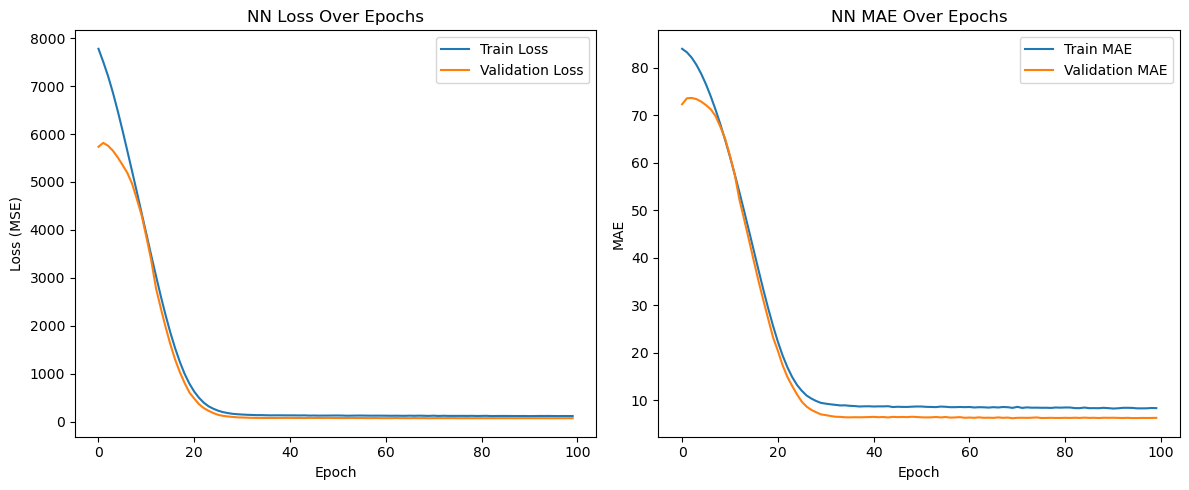

In [20]:
# ===============================
# 6.3 Neural Network Models
# ===============================

# 6.3.1 Simple Neural Network
# 6.3.1 Optimized Neural Network
def build_nn_model():
    model = Sequential([
        # Input layer with stronger regularization
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), 
              kernel_regularizer=l2(0.0005), 
              kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Hidden layers with decreasing size
        Dense(32, activation='relu', 
              kernel_regularizer=l2(0.0005), 
              kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.1),
        
        # Smaller final hidden layer
        Dense(16, activation='relu', 
              kernel_regularizer=l2(0.0005), 
              kernel_initializer='he_normal'),
        BatchNormalization(),
        
        # Output layer
        Dense(1)
    ])
    
    # Use a lower learning rate with AMSGrad for better convergence
    optimizer = Adam(learning_rate=0.0005, amsgrad=True)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    return model

nn_model = build_nn_model()

# Improved callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=30,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  # More gradual reduction
    patience=10, 
    min_lr=0.00001,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'model_results/best_nn_model.h5', 
    save_best_only=True, 
    monitor='val_loss',
    verbose=1
)

# Train with class_weight to handle any imbalance in the target variable
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=300,  # Increased max epochs
    batch_size=16,  # Smaller batch size for better generalization with small dataset
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

y_pred_nn = nn_model.predict(X_test_scaled).flatten()
nn_results = evaluate_model("Neural Network", y_test, y_pred_nn)
all_model_results.append(nn_results)


# Plot training history for Simple Neural Network
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('NN Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('NN MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig('model_results/nn_training_history.png')

In [21]:
input_dim = X_train_scaled.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

Training sequences shape: (3207, 3, 18)
Testing sequences shape: (800, 3, 18)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 3, 128)              │          42,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,721 (338.75 KB)

 Trainable params: 86,273 (337.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7750.3599 - mae: 84.1330 - mse: 7750.3149
Epoch 1: val_loss improved from inf to 5618.07129, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 7743.4014 - mae: 84.1186 - mse: 7743.3569 - val_loss: 5618.0713 - val_mae: 71.3333 - val_mse: 5618.0259 - learning_rate: 5.0000e-04
Epoch 2/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7346.4575 - mae: 83.0549 - mse: 7346.4106
Epoch 2: val_loss did not improve from 5618.07129
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7344.1255 - mae: 83.0454 - mse: 7344.0786 - val_loss: 5692.4771 - val_mae: 73.2307 - val_mse: 5692.4316 - learning_rate: 5.0000e-04
Epoch 3/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6905.0303 - mae: 81.2492 - mse: 6904.9854
Epoch 3: val_loss did not improve from 5618.07129
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6901.6768 - mae: 81.2324 - mse: 6901.6318 - val_loss: 5705.2368 - val_mae: 74.4138 - val_mse: 5705.1909 - learning_rate: 5.0000e-04
Epoch 4/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6412.9717 - mae: 78.7462 - mse: 6412.9272
Epoch 4: val_loss improved from 5618.07129 to 5

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6404.3403 - mae: 78.6971 - mse: 6404.2959 - val_loss: 5617.0376 - val_mae: 74.2458 - val_mse: 5616.9927 - learning_rate: 5.0000e-04
Epoch 5/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5864.3359 - mae: 75.5039 - mse: 5864.2900
Epoch 5: val_loss improved from 5617.03760 to 5267.43848, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5863.3955 - mae: 75.4977 - mse: 5863.3496 - val_loss: 5267.4385 - val_mae: 71.9728 - val_mse: 5267.3931 - learning_rate: 5.0000e-04
Epoch 6/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5296.5312 - mae: 71.7445 - mse: 5296.4863
Epoch 6: val_loss improved from 5267.43848 to 4942.07617, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5289.7822 - mae: 71.6964 - mse: 5289.7378 - val_loss: 4942.0762 - val_mae: 69.6263 - val_mse: 4942.0298 - learning_rate: 5.0000e-04
Epoch 7/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4691.1157 - mae: 67.3555 - mse: 4691.0708
Epoch 7: val_loss improved from 4942.07617 to 4077.19775, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4686.9341 - mae: 67.3236 - mse: 4686.8892 - val_loss: 4077.1978 - val_mae: 63.2453 - val_mse: 4077.1514 - learning_rate: 5.0000e-04
Epoch 8/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4039.5215 - mae: 62.3793 - mse: 4039.4763
Epoch 8: val_loss improved from 4077.19775 to 3452.57080, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4038.4331 - mae: 62.3704 - mse: 4038.3879 - val_loss: 3452.5708 - val_mae: 58.1229 - val_mse: 3452.5249 - learning_rate: 5.0000e-04
Epoch 9/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3383.1030 - mae: 56.9235 - mse: 3383.0571
Epoch 9: val_loss improved from 3452.57080 to 2677.51123, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3374.8845 - mae: 56.8492 - mse: 3374.8384 - val_loss: 2677.5112 - val_mae: 51.0693 - val_mse: 2677.4653 - learning_rate: 5.0000e-04
Epoch 10/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2743.2463 - mae: 51.0644 - mse: 2743.2002
Epoch 10: val_loss improved from 2677.51123 to 2131.12207, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2734.7661 - mae: 50.9774 - mse: 2734.7202 - val_loss: 2131.1221 - val_mae: 45.3799 - val_mse: 2131.0762 - learning_rate: 5.0000e-04
Epoch 11/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2163.5896 - mae: 45.0073 - mse: 2163.5439
Epoch 11: val_loss improved from 2131.12207 to 1648.81873, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2155.7930 - mae: 44.9193 - mse: 2155.7476 - val_loss: 1648.8187 - val_mae: 39.7234 - val_mse: 1648.7726 - learning_rate: 5.0000e-04
Epoch 12/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1644.9380 - mae: 38.8967 - mse: 1644.8920
Epoch 12: val_loss improved from 1648.81873 to 1136.00159, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1640.5272 - mae: 38.8377 - mse: 1640.4811 - val_loss: 1136.0016 - val_mae: 32.6599 - val_mse: 1135.9556 - learning_rate: 5.0000e-04
Epoch 13/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1210.0474 - mae: 32.9274 - mse: 1210.0015
Epoch 13: val_loss improved from 1136.00159 to 861.54401, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1206.6034 - mae: 32.8709 - mse: 1206.5575 - val_loss: 861.5440 - val_mae: 28.1281 - val_mse: 861.4982 - learning_rate: 5.0000e-04
Epoch 14/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 871.2998 - mae: 27.3585 - mse: 871.2537
Epoch 14: val_loss improved from 861.54401 to 564.10388, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 868.1737 - mae: 27.2975 - mse: 868.1276 - val_loss: 564.1039 - val_mae: 22.2453 - val_mse: 564.0576 - learning_rate: 5.0000e-04
Epoch 15/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 615.0532 - mae: 22.3124 - mse: 615.0069
Epoch 15: val_loss improved from 564.10388 to 384.18384, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 612.4695 - mae: 22.2536 - mse: 612.4232 - val_loss: 384.1838 - val_mae: 18.0336 - val_mse: 384.1375 - learning_rate: 5.0000e-04
Epoch 16/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 431.2417 - mae: 18.0240 - mse: 431.1952
Epoch 16: val_loss improved from 384.18384 to 277.84952, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 431.0282 - mae: 18.0180 - mse: 430.9818 - val_loss: 277.8495 - val_mae: 14.8078 - val_mse: 277.8031 - learning_rate: 5.0000e-04
Epoch 17/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 310.0630 - mae: 14.7006 - mse: 310.0165
Epoch 17: val_loss improved from 277.84952 to 208.12202, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 309.2738 - mae: 14.6738 - mse: 309.2273 - val_loss: 208.1220 - val_mae: 12.4928 - val_mse: 208.0755 - learning_rate: 5.0000e-04
Epoch 18/300
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 237.3551 - mae: 12.4970 - mse: 237.3086
Epoch 18: val_loss improved from 208.12202 to 135.50533, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 237.1480 - mae: 12.4887 - mse: 237.1015 - val_loss: 135.5053 - val_mae: 9.6112 - val_mse: 135.4587 - learning_rate: 5.0000e-04
Epoch 19/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 186.6879 - mae: 10.8071 - mse: 186.6413
Epoch 19: val_loss improved from 135.50533 to 102.76328, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 186.3618 - mae: 10.7948 - mse: 186.3152 - val_loss: 102.7633 - val_mae: 8.0648 - val_mse: 102.7167 - learning_rate: 5.0000e-04
Epoch 20/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 156.6563 - mae: 9.7427 - mse: 156.6097
Epoch 20: val_loss improved from 102.76328 to 78.19149, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 156.3811 - mae: 9.7329 - mse: 156.3345 - val_loss: 78.1915 - val_mae: 6.7735 - val_mse: 78.1448 - learning_rate: 5.0000e-04
Epoch 21/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 139.3259 - mae: 9.1601 - mse: 139.2792
Epoch 21: val_loss did not improve from 78.19149
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 139.1171 - mae: 9.1505 - mse: 139.0704 - val_loss: 78.7136 - val_mae: 6.8189 - val_mse: 78.6668 - learning_rate: 5.0000e-04
Epoch 22/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 126.2994 - mae: 8.5699 - mse: 126.2526
Epoch 22: val_loss improved from 78.19149 to 74.00459, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 126.2593 - mae: 8.5685 - mse: 126.2126 - val_loss: 74.0046 - val_mae: 6.5689 - val_mse: 73.9578 - learning_rate: 5.0000e-04
Epoch 23/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 120.5949 - mae: 8.4254 - mse: 120.5481
Epoch 23: val_loss improved from 74.00459 to 65.83793, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 120.6215 - mae: 8.4275 - mse: 120.5747 - val_loss: 65.8379 - val_mae: 6.1207 - val_mse: 65.7911 - learning_rate: 5.0000e-04
Epoch 24/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 116.9995 - mae: 8.3053 - mse: 116.9526
Epoch 24: val_loss did not improve from 65.83793
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 117.0282 - mae: 8.3073 - mse: 116.9813 - val_loss: 68.9401 - val_mae: 6.2804 - val_mse: 68.8932 - learning_rate: 5.0000e-04
Epoch 25/300
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 116.6733 - mae: 8.3962 - mse: 116.6264
Epoch 25: val_loss improved from 65.83793 to 63.65776, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 116.6716 - mae: 8.3962 - mse: 116.6246 - val_loss: 63.6578 - val_mae: 5.9518 - val_mse: 63.6108 - learning_rate: 5.0000e-04
Epoch 26/300
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 112.1638 - mae: 8.1526 - mse: 112.1168
Epoch 26: val_loss did not improve from 63.65776
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 112.1674 - mae: 8.1531 - mse: 112.1204 - val_loss: 65.1867 - val_mae: 5.9993 - val_mse: 65.1396 - learning_rate: 5.0000e-04
Epoch 27/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 113.2115 - mae: 8.2568 - mse: 113.1644
Epoch 27: val_loss did not improve from 63.65776
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 113.1458 - mae: 8.2550 - mse: 113.0988 - val_loss: 66.0635 - val_mae: 6.0631 - val_mse: 66.0164 - learning_rate: 5.0000e-04
Epoch 28/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 108.8287 - mae: 8.0874 - mse: 108.7817
Epoch 28: val_loss improved from 63.65776 to 61.73737, saving model to model_res

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 108.8254 - mae: 8.0890 - mse: 108.7783 - val_loss: 61.7374 - val_mae: 5.8501 - val_mse: 61.6903 - learning_rate: 5.0000e-04
Epoch 29/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 110.8097 - mae: 8.1559 - mse: 110.7626
Epoch 29: val_loss did not improve from 61.73737
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 110.7231 - mae: 8.1536 - mse: 110.6760 - val_loss: 63.6797 - val_mae: 5.9630 - val_mse: 63.6326 - learning_rate: 5.0000e-04
Epoch 30/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 106.8230 - mae: 8.0340 - mse: 106.7758
Epoch 30: val_loss did not improve from 61.73737
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 106.9625 - mae: 8.0406 - mse: 106.9153 - val_loss: 62.1024 - val_mae: 5.8386 - val_mse: 62.0552 - learning_rate: 5.0000e-04
Epoch 31/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 108.5000 - mae: 8.1728 - mse: 108.4528
Epoch 31: val_loss did not improve from 61.73737
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 106.0162 - mae: 8.0069 - mse: 105.9687 - val_loss: 60.5117 - val_mae: 5.7213 - val_mse: 60.4642 - learning_rate: 5.0000e-04
Epoch 38/300
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 100.3629 - mae: 7.7565 - mse: 100.3154
Epoch 38: val_loss did not improve from 60.51174
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 100.3590 - mae: 7.7570 - mse: 100.3115 - val_loss: 63.2337 - val_mae: 5.8966 - val_mse: 63.1862 - learning_rate: 5.0000e-04
Epoch 39/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 106.8213 - mae: 8.0964 - mse: 106.7738
Epoch 39: val_loss did not improve from 60.51174
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 106.7943 - mae: 8.0961 - mse: 106.7468 - val_loss: 64.0531 - val_mae: 5.8647 - val_mse: 64.0055 - learning_rate: 5.0000e-04
Epoch 40/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 106.1250 - mae: 8.0945 - mse: 106.0774
Epoch 40: val_loss did not improve from 60.51174
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 94.0531 - mae: 7.6705 - mse: 94.0053 - val_loss: 60.4769 - val_mae: 5.7543 - val_mse: 60.4292 - learning_rate: 2.5000e-04
Epoch 52/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 96.2932 - mae: 7.7654 - mse: 96.2455
Epoch 52: val_loss did not improve from 60.47690
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 96.3170 - mae: 7.7655 - mse: 96.2693 - val_loss: 62.1312 - val_mae: 5.8124 - val_mse: 62.0834 - learning_rate: 2.5000e-04
Epoch 53/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 96.8469 - mae: 7.7800 - mse: 96.7991
Epoch 53: val_loss did not improve from 60.47690
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 96.8149 - mae: 7.7774 - mse: 96.7671 - val_loss: 61.1295 - val_mae: 5.7353 - val_mse: 61.0818 - learning_rate: 2.5000e-04
Epoch 54/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94.0485 - mae: 7.5811 - mse: 94.0007
Epoch 54: val_loss did not improve from 60.47690
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 95.0737 - mae: 7.6938 - mse: 95.0260 - val_loss: 59.8446 - val_mae: 5.6589 - val_mse: 59.7969 - learning_rate: 2.5000e-04
Epoch 61/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 92.5756 - mae: 7.6101 - mse: 92.5279
Epoch 61: val_loss improved from 59.84460 to 59.75037, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 92.6041 - mae: 7.6108 - mse: 92.5564 - val_loss: 59.7504 - val_mae: 5.6964 - val_mse: 59.7026 - learning_rate: 2.5000e-04
Epoch 62/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 95.8539 - mae: 7.6784 - mse: 95.8062
Epoch 62: val_loss improved from 59.75037 to 59.56515, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 95.8397 - mae: 7.6780 - mse: 95.7919 - val_loss: 59.5652 - val_mae: 5.6838 - val_mse: 59.5174 - learning_rate: 2.5000e-04
Epoch 63/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94.4018 - mae: 7.5874 - mse: 94.3540
Epoch 63: val_loss did not improve from 59.56515
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 94.3958 - mae: 7.5874 - mse: 94.3481 - val_loss: 59.6527 - val_mae: 5.6871 - val_mse: 59.6049 - learning_rate: 2.5000e-04
Epoch 64/300
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 92.5415 - mae: 7.5853 - mse: 92.4938
Epoch 64: val_loss did not improve from 59.56515
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 92.5611 - mae: 7.5861 - mse: 92.5134 - val_loss: 61.6729 - val_mae: 5.8021 - val_mse: 61.6251 - learning_rate: 2.5000e-04
Epoch 65/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94.2674 - mae: 7.6551 - mse: 94.2197
Epoch 65: val_loss did not improve from 59.56515
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

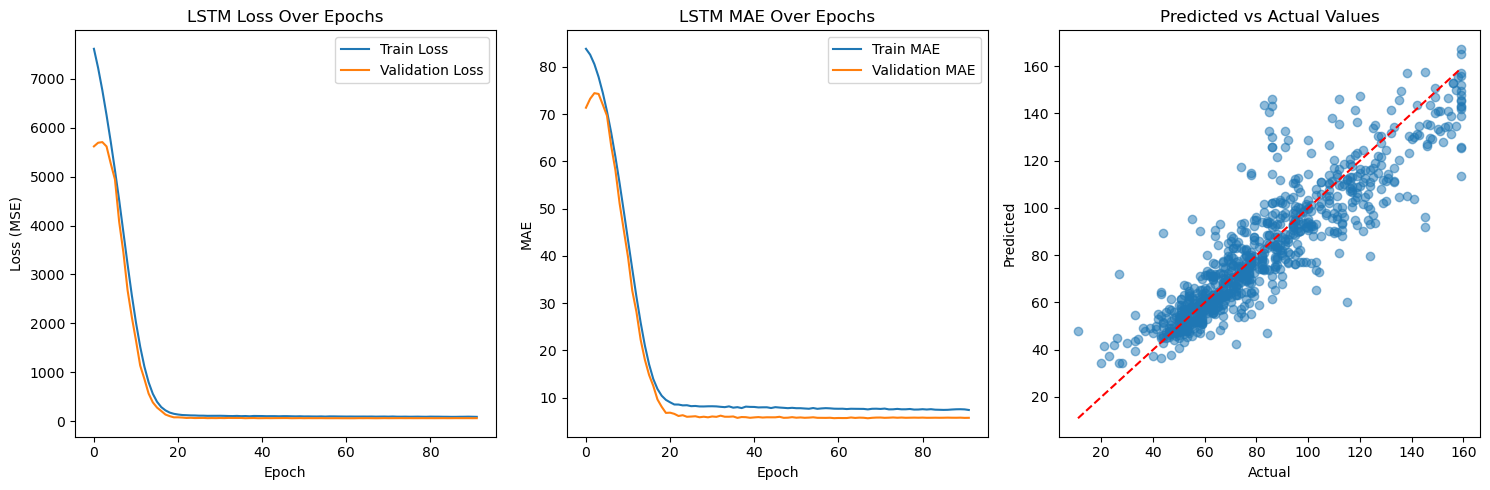

In [22]:
# 6.3.2 Enhanced LSTM Model
def build_lstm_model(input_shape, units=64):
    model = Sequential([
        # Bidirectional LSTM can capture patterns in both directions
        Bidirectional(LSTM(units, return_sequences=True, activation='tanh', 
                          recurrent_dropout=0.1), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second LSTM layer for more complex pattern recognition
        Bidirectional(LSTM(units//2, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        
        # Dense layers for final prediction
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dense(1)
    ])
    
    # Use a lower learning rate with AMSGrad for better convergence
    optimizer = Adam(learning_rate=0.0005, amsgrad=True)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    
    return model

# Create sequences for LSTM (samples, timesteps, features)
# Using multiple timesteps instead of just 1
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps - 1])  # Use .iloc for positional indexing
    return np.array(Xs), np.array(ys)



# Create sequences with multiple timesteps
time_steps = 3  # Look back 3 days to predict the next day
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Testing sequences shape: {X_test_seq.shape}")

# Build and train the enhanced LSTM model
lstm_model = build_lstm_model((time_steps, X_train_scaled.shape[1]))
lstm_model.summary()  # Print model architecture

# Improved callbacks
early_stopping_lstm = EarlyStopping(
    monitor='val_loss', 
    patience=30,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr_lstm = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  # More gradual reduction
    patience=10, 
    min_lr=0.00001,
    verbose=1
)

model_checkpoint_lstm = ModelCheckpoint(
    'model_results/best_lstm_model.h5', 
    save_best_only=True, 
    monitor='val_loss',
    verbose=1
)

# Train with class_weight to handle any imbalance in the target variable
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=300,  # Increased max epochs
    batch_size=16,  # Smaller batch size for better generalization with small dataset
    validation_split=0.2,
    callbacks=[early_stopping_lstm, reduce_lr_lstm, model_checkpoint_lstm],
    verbose=1
)

# Evaluate the model
y_pred_lstm = lstm_model.predict(X_test_seq).flatten()
lstm_results = evaluate_model("Enhanced LSTM", y_test_seq, y_pred_lstm)
all_model_results.append(lstm_results)

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_lstm.history['mae'], label='Train MAE')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE')
plt.title('LSTM MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(y_test_seq, y_pred_lstm, alpha=0.5)
plt.plot([min(y_test_seq), max(y_test_seq)], [min(y_test_seq), max(y_test_seq)], 'r--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.savefig('model_results/lstm_training_history.png')
plt.show()


Training sequences shape: (3207, 3, 18)
Testing sequences shape: (800, 3, 18)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 3, 128)              │          42,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,721 (338.75 KB)

 Trainable params: 86,273 (337.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7779.7183 - mae: 84.1566 - mse: 7779.6772
Epoch 1: val_loss improved from inf to 5608.87061, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 7775.2134 - mae: 84.1469 - mse: 7775.1724 - val_loss: 5608.8706 - val_mae: 71.1201 - val_mse: 5608.8296 - learning_rate: 5.0000e-04
Epoch 2/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7406.9712 - mae: 83.2010 - mse: 7406.9292
Epoch 2: val_loss did not improve from 5608.87061
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7399.9810 - mae: 83.1755 - mse: 7399.9390 - val_loss: 5617.0996 - val_mae: 72.5344 - val_mse: 5617.0586 - learning_rate: 5.0000e-04
Epoch 3/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6976.5322 - mae: 81.4823 - mse: 6976.4888
Epoch 3: val_loss did not improve from 5608.87061
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6969.2100 - mae: 81.4485 - mse: 6969.1660 - val_loss: 5766.7632 - val_mae: 74.7634 - val_mse: 5766.7212 - learning_rate: 5.0000e-04
Epoch 4/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6477.4419 - mae: 79.0310 - mse: 6477.4004
Epoch 4: val_loss did not improve from 5608.870

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5917.1523 - mae: 75.8310 - mse: 5917.1089 - val_loss: 5262.6880 - val_mae: 71.9927 - val_mse: 5262.6450 - learning_rate: 5.0000e-04
Epoch 6/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5353.6538 - mae: 72.1460 - mse: 5353.6113
Epoch 6: val_loss improved from 5262.68799 to 4805.80566, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5343.5317 - mae: 72.0730 - mse: 5343.4893 - val_loss: 4805.8057 - val_mae: 68.7738 - val_mse: 4805.7627 - learning_rate: 5.0000e-04
Epoch 7/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4745.1255 - mae: 67.8018 - mse: 4745.0830
Epoch 7: val_loss improved from 4805.80566 to 4317.27100, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4739.0806 - mae: 67.7553 - mse: 4739.0381 - val_loss: 4317.2710 - val_mae: 65.0865 - val_mse: 4317.2275 - learning_rate: 5.0000e-04
Epoch 8/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4116.0771 - mae: 62.9203 - mse: 4116.0342
Epoch 8: val_loss improved from 4317.27100 to 3674.66675, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4111.6401 - mae: 62.8853 - mse: 4111.5972 - val_loss: 3674.6667 - val_mae: 59.9891 - val_mse: 3674.6243 - learning_rate: 5.0000e-04
Epoch 9/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3447.7966 - mae: 57.4852 - mse: 3447.7539
Epoch 9: val_loss improved from 3674.66675 to 2925.22461, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3444.5435 - mae: 57.4564 - mse: 3444.5005 - val_loss: 2925.2246 - val_mae: 53.4002 - val_mse: 2925.1814 - learning_rate: 5.0000e-04
Epoch 10/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2802.1035 - mae: 51.6342 - mse: 2802.0601
Epoch 10: val_loss improved from 2925.22461 to 2272.55273, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2801.1125 - mae: 51.6243 - mse: 2801.0693 - val_loss: 2272.5527 - val_mae: 46.8588 - val_mse: 2272.5090 - learning_rate: 5.0000e-04
Epoch 11/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2221.1262 - mae: 45.6770 - mse: 2221.0833
Epoch 11: val_loss improved from 2272.55273 to 1757.14392, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2212.5305 - mae: 45.5797 - mse: 2212.4875 - val_loss: 1757.1439 - val_mae: 41.0614 - val_mse: 1757.1007 - learning_rate: 5.0000e-04
Epoch 12/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1690.7264 - mae: 39.5410 - mse: 1690.6832
Epoch 12: val_loss improved from 1757.14392 to 1307.76697, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1687.0425 - mae: 39.4915 - mse: 1686.9993 - val_loss: 1307.7670 - val_mae: 35.1975 - val_mse: 1307.7235 - learning_rate: 5.0000e-04
Epoch 13/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1256.6266 - mae: 33.5488 - mse: 1256.5833
Epoch 13: val_loss improved from 1307.76697 to 876.52881, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1254.1124 - mae: 33.5107 - mse: 1254.0691 - val_loss: 876.5288 - val_mae: 28.3659 - val_mse: 876.4855 - learning_rate: 5.0000e-04
Epoch 14/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 902.1235 - mae: 27.9633 - mse: 902.0805
Epoch 14: val_loss improved from 876.52881 to 602.71527, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 898.4376 - mae: 27.8934 - mse: 898.3946 - val_loss: 602.7153 - val_mae: 23.1115 - val_mse: 602.6719 - learning_rate: 5.0000e-04
Epoch 15/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 638.3073 - mae: 22.8786 - mse: 638.2639
Epoch 15: val_loss improved from 602.71527 to 420.76328, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 635.9594 - mae: 22.8242 - mse: 635.9160 - val_loss: 420.7633 - val_mae: 18.9484 - val_mse: 420.7200 - learning_rate: 5.0000e-04
Epoch 16/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 443.2396 - mae: 18.4606 - mse: 443.1963
Epoch 16: val_loss improved from 420.76328 to 300.93347, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 442.1175 - mae: 18.4280 - mse: 442.0741 - val_loss: 300.9335 - val_mae: 15.5673 - val_mse: 300.8901 - learning_rate: 5.0000e-04
Epoch 17/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 318.5281 - mae: 15.0176 - mse: 318.4846
Epoch 17: val_loss improved from 300.93347 to 185.91693, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 317.6204 - mae: 14.9869 - mse: 317.5769 - val_loss: 185.9169 - val_mae: 11.7338 - val_mse: 185.8735 - learning_rate: 5.0000e-04
Epoch 18/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 241.7281 - mae: 12.5749 - mse: 241.6847
Epoch 18: val_loss improved from 185.91693 to 139.68266, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 241.6069 - mae: 12.5709 - mse: 241.5634 - val_loss: 139.6827 - val_mae: 9.7953 - val_mse: 139.6392 - learning_rate: 5.0000e-04
Epoch 19/300
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 189.0256 - mae: 10.9314 - mse: 188.9821
Epoch 19: val_loss improved from 139.68266 to 106.14872, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 188.9004 - mae: 10.9262 - mse: 188.8569 - val_loss: 106.1487 - val_mae: 8.2026 - val_mse: 106.1052 - learning_rate: 5.0000e-04
Epoch 20/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 160.1278 - mae: 9.8465 - mse: 160.0843
Epoch 20: val_loss improved from 106.14872 to 80.14877, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 159.8216 - mae: 9.8348 - mse: 159.7780 - val_loss: 80.1488 - val_mae: 6.9012 - val_mse: 80.1052 - learning_rate: 5.0000e-04
Epoch 21/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 137.7259 - mae: 9.0859 - mse: 137.6823
Epoch 21: val_loss did not improve from 80.14877
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 137.6206 - mae: 9.0818 - mse: 137.5770 - val_loss: 82.6318 - val_mae: 6.9464 - val_mse: 82.5881 - learning_rate: 5.0000e-04
Epoch 22/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 124.2512 - mae: 8.6791 - mse: 124.2075
Epoch 22: val_loss improved from 80.14877 to 73.22493, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 124.2155 - mae: 8.6757 - mse: 124.1719 - val_loss: 73.2249 - val_mae: 6.3819 - val_mse: 73.1812 - learning_rate: 5.0000e-04
Epoch 23/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 119.0096 - mae: 8.5341 - mse: 118.9659
Epoch 23: val_loss improved from 73.22493 to 71.93023, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 119.0480 - mae: 8.5335 - mse: 119.0043 - val_loss: 71.9302 - val_mae: 6.3472 - val_mse: 71.8865 - learning_rate: 5.0000e-04
Epoch 24/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 113.0231 - mae: 8.2338 - mse: 112.9793
Epoch 24: val_loss improved from 71.93023 to 69.54102, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 113.0285 - mae: 8.2340 - mse: 112.9847 - val_loss: 69.5410 - val_mae: 6.2304 - val_mse: 69.4972 - learning_rate: 5.0000e-04
Epoch 25/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 114.7879 - mae: 8.3384 - mse: 114.7440
Epoch 25: val_loss did not improve from 69.54102
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 114.7868 - mae: 8.3375 - mse: 114.7430 - val_loss: 70.6070 - val_mae: 6.2218 - val_mse: 70.5632 - learning_rate: 5.0000e-04
Epoch 26/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 111.0712 - mae: 8.2103 - mse: 111.0273
Epoch 26: val_loss did not improve from 69.54102
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 111.0676 - mae: 8.2102 - mse: 111.0237 - val_loss: 69.6648 - val_mae: 6.1558 - val_mse: 69.6208 - learning_rate: 5.0000e-04
Epoch 27/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 109.2747 - mae: 8.0989 - mse: 109.2308
Epoch 27: val_loss did not improve from 69.54102
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 106.0557 - mae: 8.0267 - mse: 106.0118 - val_loss: 68.3004 - val_mae: 6.1036 - val_mse: 68.2564 - learning_rate: 5.0000e-04
Epoch 29/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 107.8407 - mae: 8.0220 - mse: 107.7967
Epoch 29: val_loss did not improve from 68.30036
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 107.7863 - mae: 8.0240 - mse: 107.7423 - val_loss: 69.1766 - val_mae: 6.0616 - val_mse: 69.1326 - learning_rate: 5.0000e-04
Epoch 30/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 105.7970 - mae: 8.0167 - mse: 105.7530
Epoch 30: val_loss did not improve from 68.30036
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 105.8039 - mae: 8.0170 - mse: 105.7599 - val_loss: 69.9001 - val_mae: 6.0525 - val_mse: 69.8560 - learning_rate: 5.0000e-04
Epoch 31/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 106.5614 - mae: 8.1893 - mse: 106.5174
Epoch 31: val_loss did not improve from 68.30036
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 100.3288 - mae: 7.8166 - mse: 100.2845 - val_loss: 67.9949 - val_mae: 5.9991 - val_mse: 67.9506 - learning_rate: 2.5000e-04
Epoch 42/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 101.1260 - mae: 7.8448 - mse: 101.0817
Epoch 42: val_loss improved from 67.99485 to 67.51294, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 101.1230 - mae: 7.8447 - mse: 101.0787 - val_loss: 67.5129 - val_mae: 5.9639 - val_mse: 67.4687 - learning_rate: 2.5000e-04
Epoch 43/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 101.1122 - mae: 7.8888 - mse: 101.0680
Epoch 43: val_loss did not improve from 67.51294
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 101.0841 - mae: 7.8874 - mse: 101.0399 - val_loss: 68.3879 - val_mae: 6.0075 - val_mse: 68.3437 - learning_rate: 2.5000e-04
Epoch 44/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 98.8879 - mae: 7.7928 - mse: 98.8437
Epoch 44: val_loss did not improve from 67.51294
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 98.8690 - mae: 7.7929 - mse: 98.8247 - val_loss: 68.8271 - val_mae: 6.0357 - val_mse: 68.7829 - learning_rate: 2.5000e-04
Epoch 45/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 99.1578 - mae: 7.8260 - mse: 99.1136
Epoch 45: val_loss did not improve from 67.51294
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 93.2812 - mae: 7.6078 - mse: 93.2370 - val_loss: 66.4587 - val_mae: 5.9189 - val_mse: 66.4145 - learning_rate: 2.5000e-04
Epoch 50/300
150/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 96.3502 - mae: 7.7987 - mse: 96.3060
Epoch 50: val_loss did not improve from 66.45872
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 96.2724 - mae: 7.7931 - mse: 96.2282 - val_loss: 68.1220 - val_mae: 6.0429 - val_mse: 68.0778 - learning_rate: 2.5000e-04
Epoch 51/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 96.3413 - mae: 7.6774 - mse: 96.2971
Epoch 51: val_loss did not improve from 66.45872
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 96.3433 - mae: 7.6770 - mse: 96.2991 - val_loss: 69.4832 - val_mae: 6.0798 - val_mse: 69.4390 - learning_rate: 2.5000e-04
Epoch 52/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 97.2859 - mae: 7.7494 - mse: 97.2418
Epoch 52: val_loss did not improve from 66.45872
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

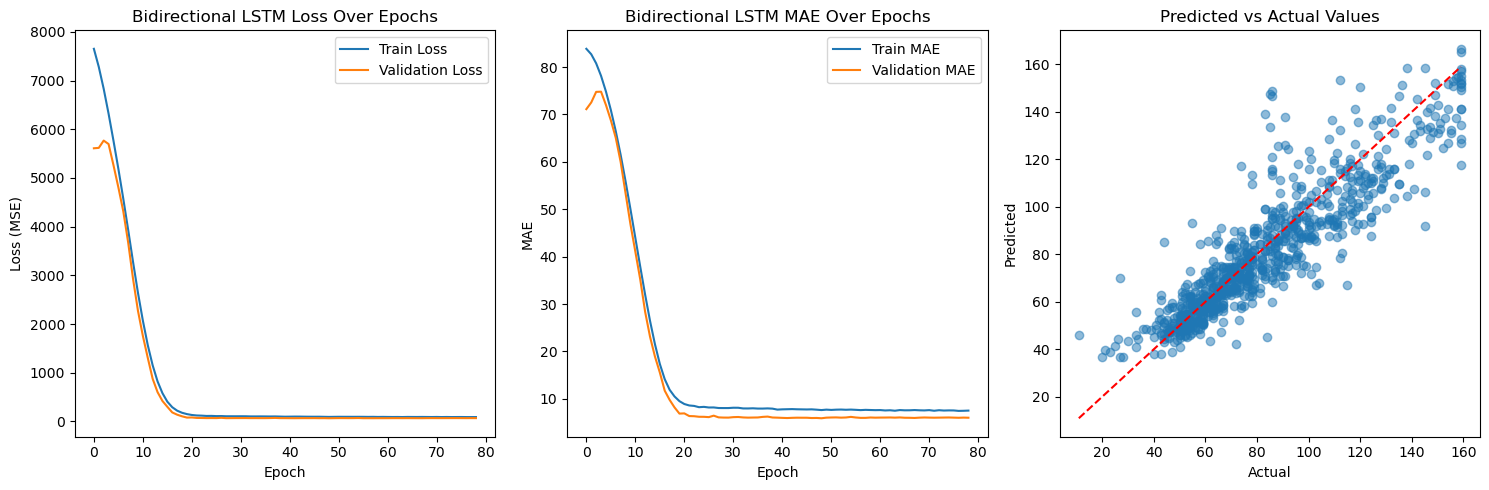

In [23]:
# 6.3.3 Enhanced Bidirectional LSTM Model
def build_bilstm_model(input_shape, units=64):
    model = Sequential([
        # First Bidirectional LSTM layer with return sequences
        Bidirectional(LSTM(units, return_sequences=True, activation='tanh', 
                           recurrent_dropout=0.1), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second Bidirectional LSTM layer
        Bidirectional(LSTM(units//2, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        
        # Dense layers for final prediction
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dense(1)
    ])
    
    # Use a lower learning rate with AMSGrad for better convergence
    optimizer = Adam(learning_rate=0.0005, amsgrad=True)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    
    return model

# Create sequences for LSTM (samples, timesteps, features)
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps - 1])  # Use .iloc for positional indexing
    return np.array(Xs), np.array(ys)


# Create sequences with multiple timesteps
time_steps = 3  # Look back 3 days to predict the next day
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Testing sequences shape: {X_test_seq.shape}")

# Build and train the enhanced Bidirectional LSTM model
bilstm_model = build_bilstm_model((time_steps, X_train_scaled.shape[1]))
bilstm_model.summary()  # Print model architecture

# Improved callbacks
early_stopping_bilstm = EarlyStopping(
    monitor='val_loss', 
    patience=30,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr_bilstm = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  # More gradual reduction
    patience=10, 
    min_lr=0.00001,
    verbose=1
)

model_checkpoint_bilstm = ModelCheckpoint(
    'model_results/best_bilstm_model.h5', 
    save_best_only=True, 
    monitor='val_loss',
    verbose=1
)

# Train with class_weight to handle any imbalance in the target variable
history_bilstm = bilstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=300,  # Increased max epochs
    batch_size=16,  # Smaller batch size for better generalization with small dataset
    validation_split=0.2,
    callbacks=[early_stopping_bilstm, reduce_lr_bilstm, model_checkpoint_bilstm],
    verbose=1
)

# Evaluate the model
y_pred_bilstm = bilstm_model.predict(X_test_seq).flatten()
bilstm_results = evaluate_model("Enhanced Bidirectional LSTM", y_test_seq, y_pred_bilstm)
all_model_results.append(bilstm_results)

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_bilstm.history['mae'], label='Train MAE')
plt.plot(history_bilstm.history['val_mae'], label='Validation MAE')
plt.title('Bidirectional LSTM MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(y_test_seq, y_pred_bilstm, alpha=0.5)
plt.plot([min(y_test_seq), max(y_test_seq)], [min(y_test_seq), max(y_test_seq)], 'r--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.savefig('model_results/bilstm_training_history.png')
plt.show()


In [25]:
# ===============================
# 6.5.2 Stacking Regressor
# ===============================
from sklearn.model_selection import KFold

# Define base models
base_models = [
    ('elasticnet_cv', elasticnet_cv_grid),
    ('xgb', xgb_grid.best_estimator_),
    ('gb', gb_grid.best_estimator_),
    ('cb', cb_model),
    ('ridge', ridge_cv_grid.best_estimator_)
]

# Define meta-learner
meta_learner = Ridge(alpha=1.0)

# Create stacking regressor using KFold cross-validation
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

stacking_regressor.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_regressor.predict(X_test_scaled)
stacking_results = evaluate_model("Stacking Regressor", y_test, y_pred_stacking)
all_model_results.append(stacking_results)



Stacking Regressor Performance:
MSE: 161.7381
RMSE: 12.7176
MAE: 9.0171
MAPE: 11.61%
R²: 0.8217
Explained Variance: 0.8233


In [26]:
# ===============================
# 6.5.3 Weighted Ensemble (based on validation performance)
# ===============================

# Get the top 5 models based on R²
top_models = sorted(all_model_results, key=lambda x: x['R²'], reverse=True)[:5]
top_model_names = [model['Model'] for model in top_models]
print("\nTop 5 models for weighted ensemble:")
for model in top_models:
    print(f"{model['Model']}: R² = {model['R²']:.4f}")

# Create weights based on R² scores
weights = np.array([model['R²'] for model in top_models])
weights = weights / np.sum(weights)  # Normalize weights

# Initialize weighted prediction
y_pred_weighted = np.zeros_like(y_test, dtype=float)

# Add weighted predictions based on each model's performance
for i, model_name in enumerate(top_model_names):
    if model_name == "Random Forest":
        y_pred_weighted += weights[i] * y_pred_rf
    elif model_name == "XGBoost":
        y_pred_weighted += weights[i] * y_pred_xgb
    elif model_name == "LightGBM":
        y_pred_weighted += weights[i] * y_pred_lgb
    elif model_name == "CatBoost":
        y_pred_weighted += weights[i] * y_pred_cb
    elif model_name == "Neural Network":
        y_pred_weighted += weights[i] * y_pred_nn
    elif model_name == "LSTM":
        y_pred_weighted += weights[i] * y_pred_lstm
    elif model_name == "Bidirectional LSTM":
        y_pred_weighted += weights[i] * y_pred_bilstm
    elif model_name == "Stacking Regressor":
        y_pred_weighted += weights[i] * y_pred_stacking
    elif model_name == "Ridge Regression":
        y_pred_weighted += weights[i] * y_pred_ridge
    elif model_name == "Lasso Regression":
        y_pred_weighted += weights[i] * y_pred_lasso
    elif model_name == "ElasticNet":
        y_pred_weighted += weights[i] * y_pred_elasticnet
    elif model_name == "Gradient Boosting":
        y_pred_weighted += weights[i] * y_pred_gb
    elif model_name == "Linear Regression":
        y_pred_weighted += weights[i] * y_pred_lr

weighted_ensemble_results = evaluate_model("Weighted Ensemble", y_test, y_pred_weighted)
all_model_results.append(weighted_ensemble_results)



Top 5 models for weighted ensemble:
Gradient Boosting: R² = 0.8224
Stacking Regressor: R² = 0.8217
XGBoost: R² = 0.8208
CatBoost: R² = 0.8094
ElasticNet: R² = 0.8051

Weighted Ensemble Performance:
MSE: 161.6947
RMSE: 12.7159
MAE: 9.0870
MAPE: 11.62%
R²: 0.8217
Explained Variance: 0.8243


In [27]:
# Create a comparison table of all models
results_df = pd.DataFrame(all_model_results)
print("\nModel Comparison:")
print(results_df.sort_values('R²', ascending=False))

# Save results to CSV
results_df.to_csv('model_results/model_comparison.csv', index=False)


Model Comparison:
                          Model         MSE       RMSE       MAE      MAPE  \
5             Gradient Boosting  161.048962  12.690507  8.982157  0.117596   
13            Weighted Ensemble  161.694741  12.715925  9.087006  0.116245   
12           Stacking Regressor  161.738073  12.717628  9.017130  0.116061   
6                       XGBoost  162.573096  12.750416  9.136553  0.118170   
8                      CatBoost  172.896621  13.149016  9.468689  0.118981   
3                    ElasticNet  176.788732  13.296192  9.423398  0.117949   
1              Ridge Regression  176.814272  13.297153  9.384055  0.117708   
0             Linear Regression  178.614356  13.364668  9.391798  0.117982   
2              Lasso Regression  179.537216  13.399150  9.481939  0.118248   
7                      LightGBM  180.620240  13.439503  9.502943  0.121768   
11  Enhanced Bidirectional LSTM  182.650323  13.514819  9.678507  0.124645   
10                Enhanced LSTM  182.702224  

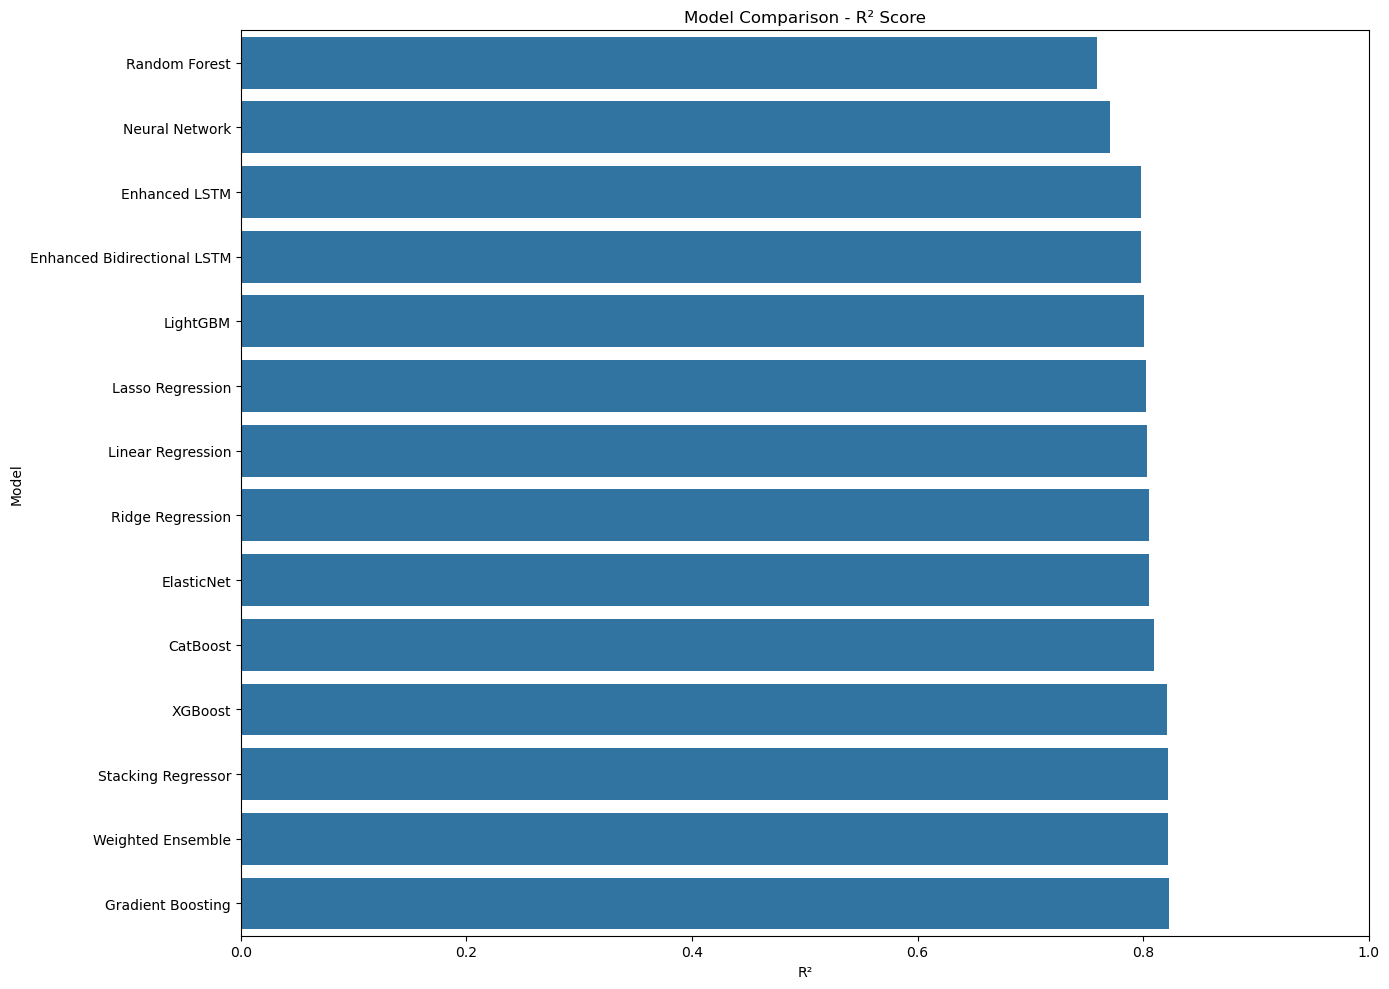

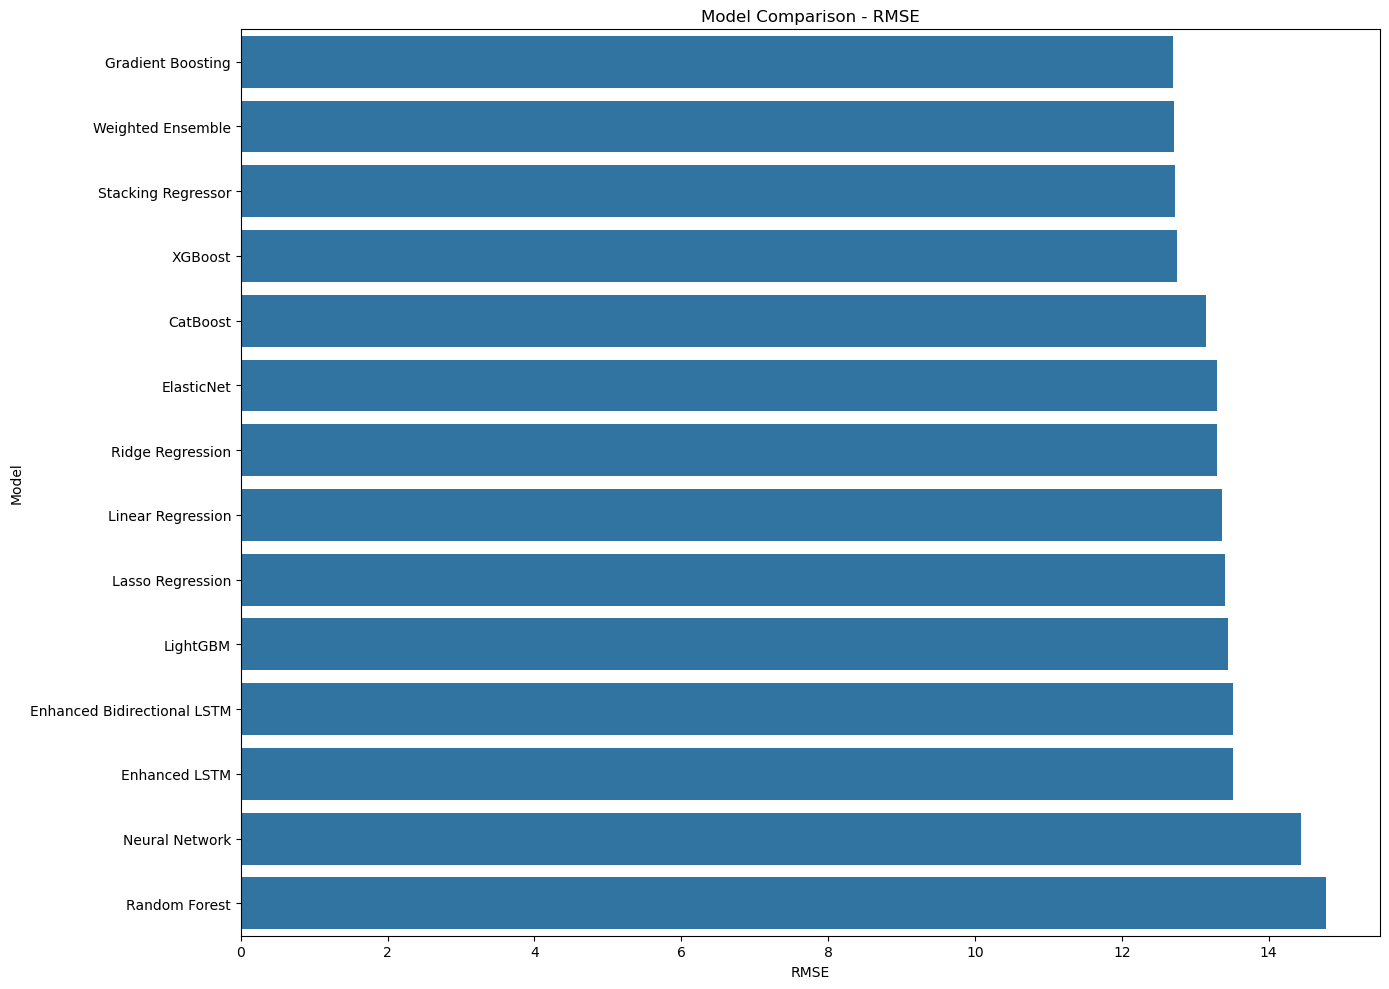

In [28]:
# Plot model comparison - R²
plt.figure(figsize=(14, 10))
sns.barplot(x='R²', y='Model', data=results_df.sort_values('R²'))
plt.title('Model Comparison - R² Score')
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('model_results/model_comparison_r2.png')
plt.show()

# Plot model comparison - RMSE
plt.figure(figsize=(14, 10))
sns.barplot(x='RMSE', y='Model', data=results_df.sort_values('RMSE'))
plt.title('Model Comparison - RMSE')
plt.tight_layout()
plt.savefig('model_results/model_comparison_rmse.png')
plt.show()

In [29]:
# Plot actual vs predicted for best model
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
print(f"\nBest performing model: {best_model_name}")

# Get predictions from best model
if best_model_name == "Linear Regression":
    y_pred_best = y_pred_lr
elif best_model_name == "Ridge Regression":
    y_pred_best = y_pred_ridge
elif best_model_name == "Lasso Regression":
    y_pred_best = y_pred_lasso
elif best_model_name == "ElasticNet":
    y_pred_best = y_pred_elasticnet
elif best_model_name == "Random Forest":
    y_pred_best = y_pred_rf
elif best_model_name == "Gradient Boosting":
    y_pred_best = y_pred_gb
elif best_model_name == "XGBoost":
    y_pred_best = y_pred_xgb
elif best_model_name == "LightGBM":
    y_pred_best = y_pred_lgb
elif best_model_name == "CatBoost":
    y_pred_best = y_pred_cb
elif best_model_name == "Neural Network":
    y_pred_best = y_pred_nn
elif best_model_name == "LSTM":
    y_pred_best = y_pred_lstm
elif best_model_name == "Bidirectional LSTM":
    y_pred_best = y_pred_bilstm
elif best_model_name == "Voting Regressor":
    y_pred_best = y_pred_voting
elif best_model_name == "Stacking Regressor":
    y_pred_best = y_pred_stacking
elif best_model_name == "Weighted Ensemble":
    y_pred_best = y_pred_weighted
else:
    y_pred_best = y_pred_weighted


Best performing model: Gradient Boosting


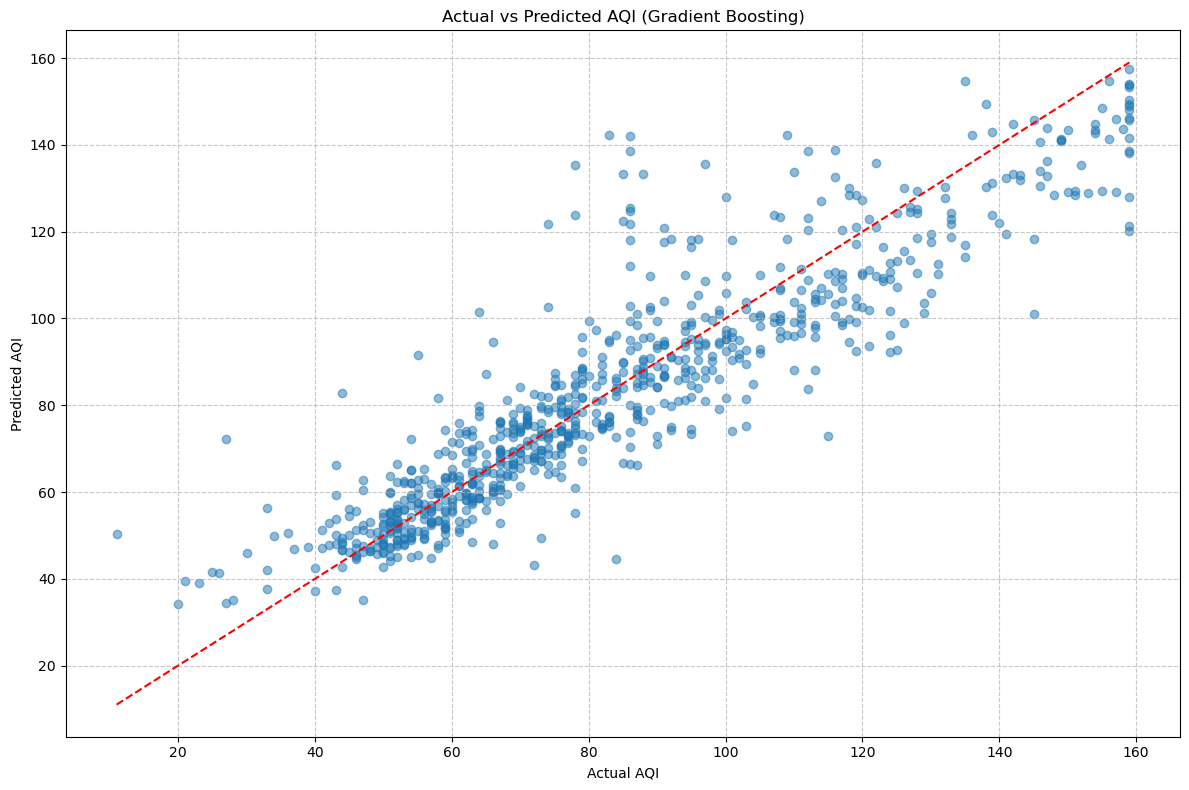

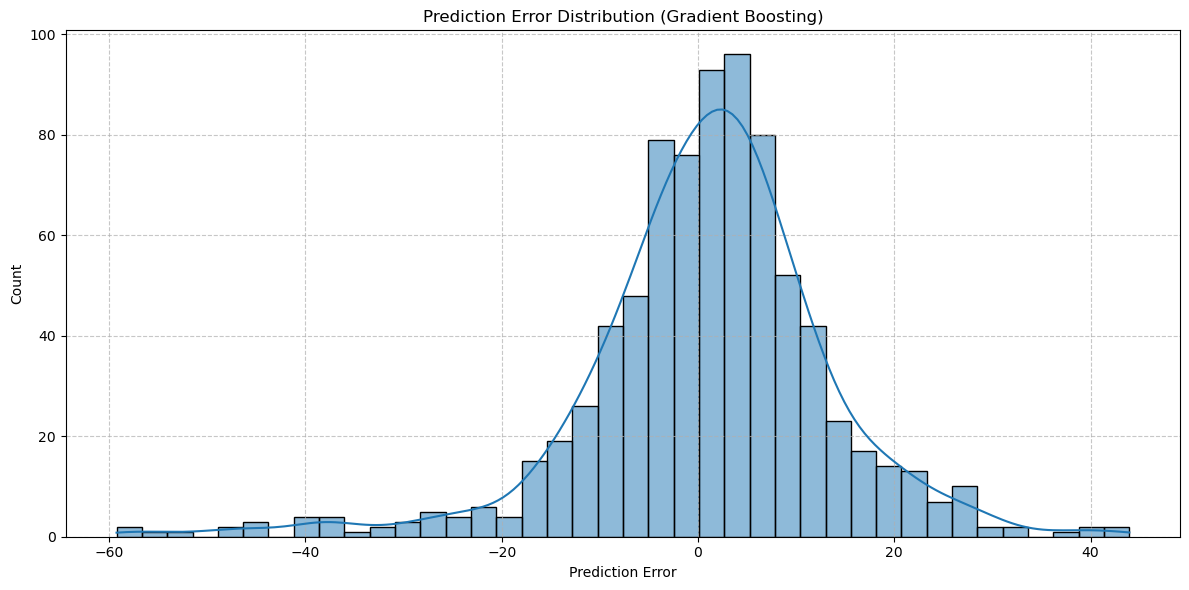

In [30]:
# Plot actual vs predicted
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title(f'Actual vs Predicted AQI ({best_model_name})')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_results/actual_vs_predicted.png')

# Plot prediction error distribution
error = y_test - y_pred_best
plt.figure(figsize=(12, 6))
sns.histplot(error, kde=True)
plt.title(f'Prediction Error Distribution ({best_model_name})')
plt.xlabel('Prediction Error')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_results/error_distribution.png')

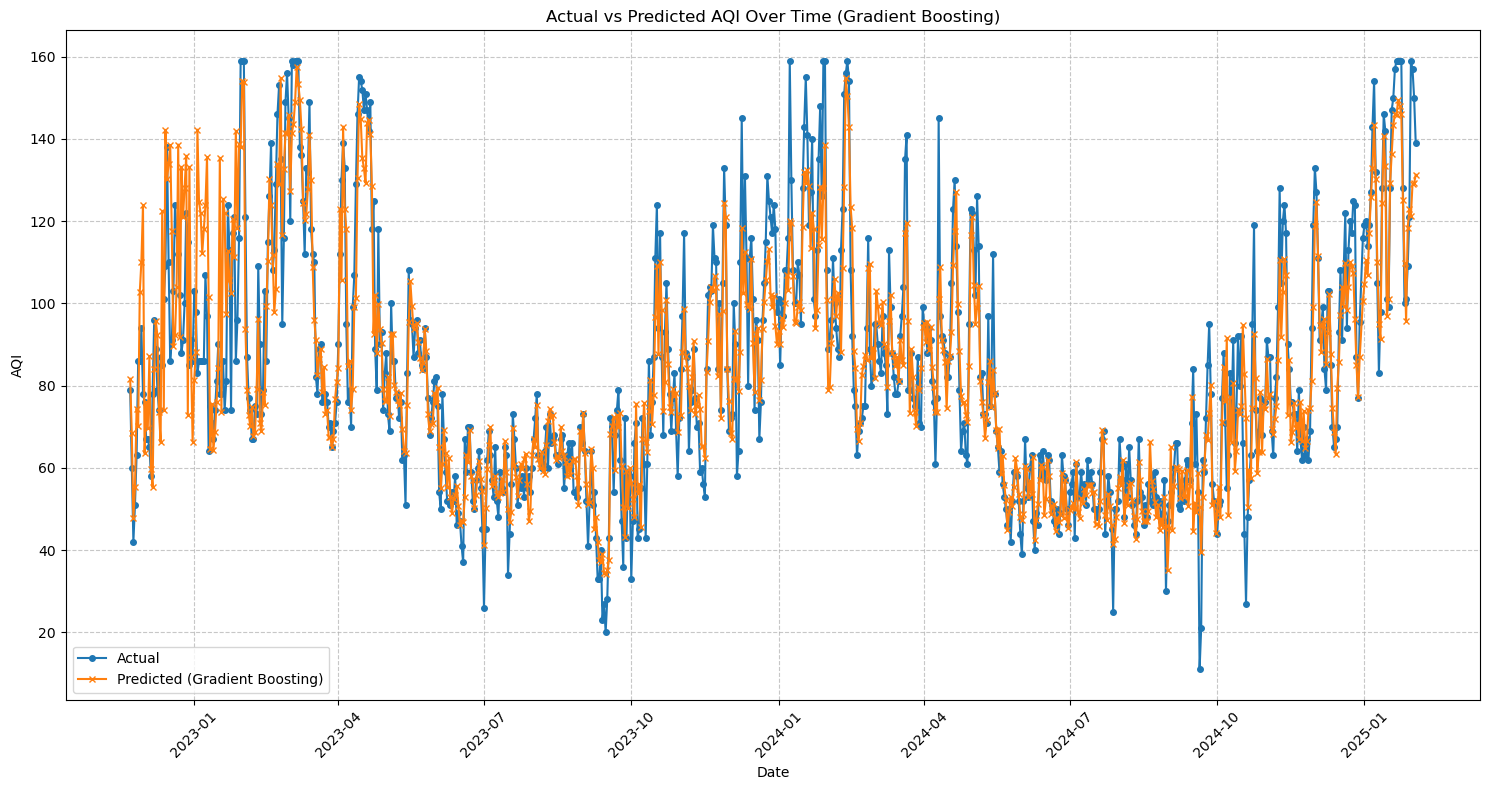

In [31]:
# Plot time series of actual vs predicted
plt.figure(figsize=(15, 8))
plt.plot(df['date'][split_idx:split_idx+len(y_test)], y_test, label='Actual', marker='o', markersize=4)
plt.plot(df['date'][split_idx:split_idx+len(y_test)], y_pred_best, label=f'Predicted ({best_model_name})', marker='x', markersize=4)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title(f'Actual vs Predicted AQI Over Time ({best_model_name})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_results/time_series_prediction.png')

In [32]:
# ===============================
# 7. Future Data Prediction
# ===============================
print("\n--- Processing Future Data and Making Predictions ---")

# Create future data dictionary
future_dict = {
    'date': ["4/2/2025", "5/2/2025", "6/2/2025", "7/2/2025", "8/2/2025", "9/2/2025",
             "10/2/2025", "11/2/2025", "12/2/2025", "13/2/2025", "14/2/2025", "15/2/2025",
             "16/2/2025", "17/2/2025", "18/2/2025", "19/2/2025", "20/2/2025", "21/2/2025",
             "22/2/2025", "23/2/2025", "24/2/2025", "25/2/2025", "26/2/2025", "27/2/2025",
             "28/2/2025", "1/3/2025", "2/3/2025", "3/3/2025", "4/3/2025", "5/3/2025"],
    'pm25': [122, 134, 108, 118, 115, 86, 86, 126, 160, 153, 137, 130, 123, 94, 74, 91, 112, 126, 116, 106, 80, 84, 80, 100, 108, 85, 78, 81, 76, 67],
    'pm10': [63, 56, 58, 53, 44, 52, 62, 69, 63, 61, 59, 61, 53, 48, 48, 47, 49, 48, 43, 30, 39, 32, 40, 45, 42, 43, 42, 43, 45, 44],
    'o3': [19, 22, 23, 18, 19, 19, 21, 22, 26, 23, 23, 26, 21, 19, 16, 18, 15, 16, 16, 13, 9, 12, 15, 18, 19, 19, 17, 22, 20, 24],
    'no2': [1, 2, 1, np.nan, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, np.nan, np.nan, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1],
    'so2': [np.nan]*30,
    'co': [np.nan]*30,
    'tempmax': [33.7, 33.9, 33.3, 33.9, 34, 31.8, 33.1, 35.7, 36.3, 35.5, 35, 36.6, 36.7, 34.2, 33.1, 32.9, 34.7, 31.3, 34.9, 34.5, 30.2, 31.2, 33, 35.6, 34.5, 34.5, 35, 34.7, 35.9, 34.9],
    'tempmin': [26, 25.4, 25.5, 24.9, 26.6, 23.5, 21.6, 20.4, 24.1, 25.6, 25.4, 25.4, 24.8, 26.9, 26.8, 26.4, 26.1, 26.8, 26.1, 26.8, 26, 24.4, 22.9, 25.1, 27.2, 27.1, 27.2, 27.7, 27.6, 27.6],
    'temp': [29, 28.9, 28.8, 28.9, 29.5, 27.5, 27.3, 28.4, 29.3, 29.9, 29.6, 30.1, 29.8, 29.6, 28.4, 29.1, 30, 28.9, 30.1, 30.7, 27.5, 26.6, 27.5, 30.1, 30.1, 29.9, 30.3, 30.4, 30.3, 30.3],
    'dew': [21.8, 19.8, 22.9, 23.3, 20.1, 16.7, 16.5, 16.8, 19.3, 21.6, 23.7, 23.1, 22.8, 24.2, 24.2, 24.4, 23.6, 24.6, 23.6, 22.9, 21.8, 20.2, 20.4, 21.6, 23.7, 24.9, 24.5, 24.7, 23.6, 24.6],
    'humidity': [67, 59, 72.3, 72.8, 59.9, 52.7, 52.9, 51.9, 57.6, 63.6, 72.5, 68.8, 69.1, 73.8, 78.6, 76.2, 70.3, 78.1, 70.2, 65.1, 71.5, 69.1, 66.2, 62.2, 69.8, 75.6, 72.5, 73.1, 69.3, 72.6],
    'precip': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.048, 13.643, 6.205, 0.016, 6.139, 0.222, 0.084, 2.006, 0.179, 0, 0, 0, 0.659, 0, 0, 22.6, 11.9],
    'windspeed': [10, 8.7, 9.5, 9.1, 14.7, 12.7, 12, 8.2, 9, 9.7, 11.2, 9.8, 11.5, 16.6, 8.3, 8.9, 8.1, 10.9, 9.4, 13.7, 14.9, 18, 11.5, 8.1, 11.9, 10.5, 10.1, 13, 22.6, 11.9],
    'winddir': [106.3, 118, 175.9, 177, 97.7, 58.6, 25.9, 94.5, 257.8, 171.7, 172.7, 194.1, 189.1, 173.3, 176.1, 168.6, 154.4, 176.9, 115.8, 84.9, 65.6, 335.1, 322.7, 313.7, 172.4, 176.6, 173.2, 179.6, 176.1, 175.7],
    'sealevelpressure': [1011.1, 1010.5, 1009.7, 1010.3, 1011.5, 1012.7, 1012.8, 1012, 1011.1, 1010.7, 1010.2, 1009.1, 1009.6, 1011.5, 1012.2, 1011.7, 1011.5, 1012.3, 1012.4, 1013.1, 1015.3, 1016.8, 1015.5, 1012.6, 1011.3, 1010.3, 1008.4, 1008.1, 1007.7, 1007.2],
    'cloudcover': [25.5, 29, 15.6, 44.3, 37, 33, 18.6, 39.3, 34.7, 15.6, 28.7, 32.4, 17.2, 38.9, 47.2, 40.7, 35, 37.6, 42.3, 47.9, 71, 60.7, 42.1, 36.6, 37.1, 44.6, 31.8, 32.4, 30.5, 28.8],
    'visibility': [8.6, 9.8, 9.1, 8.9, 9.2, 9.9, 10, 10, 8.6, 8.5, 8.6, 8.7, 9.1, 9.5, 9.8, 9.8, 9, 9, 9.2, 9.7, 9.9, 9.9, 10, 10, 10, 10, 10, 10, 10, 10],
    'solarradiation': [136.8, 151.7, 151.8, 121.3, 159.1, 167.5, 172, 174.1, 128, 155.7, 122.9, 162, 267.8, 147.3, 107.3, 162, 150, 115.4, 154.7, 160.5, 75.8, 117.5, 163.6, 190, 147.6, 165.2, 189.1, 163.9, 175.7, 177.5],
    'solarenergy': [11.8, 13.1, 13.3, 10.5, 13.8, 14.4, 15, 15.1, 11.2, 13.4, 10.7, 14.1, 23.2, 12.6, 9.3, 14.2, 12.9, 9.9, 13.4, 13.9, 6.5, 10.1, 14.1, 16.2, 12.7, 14.2, 16.4, 14.2, 15.2, 15.3],
    'uvindex': [6, 6, 6, 5, 6, 6, 7, 7, 6, 7, 6, 6, 9, 6, 4, 6, 6, 6, 6, 6, 4, 8, 7, 7, 7, 7, 7, 6, 7, 8],
    'conditions_Partially cloudy': [True, True, True, True, True, True, False, True, True, False, True, True, False, False, False, False, False, False, False, False, False, False, True, True, True, False, True, True, True, True],
    'conditions_Rain, Partially cloudy': [False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, False, False, False, True, False, False, False, False]
}


--- Processing Future Data and Making Predictions ---


In [33]:
future_data = pd.DataFrame(future_dict)

# Convert date to datetime
future_data['date'] = pd.to_datetime(future_data['date'], format='%d/%m/%Y', errors='coerce')

# Add missing one-hot encoded columns (set to 0)
future_data['conditions_Overcast'] = 0
future_data['conditions_Rain, Overcast'] = 0

# Fill missing no2 and so2 using the mean from historical data
no2_mean = df['no2'].mean()
so2_mean = df['so2'].mean()
future_data['no2'] = future_data['no2'].fillna(no2_mean)
future_data['so2'] = future_data['so2'].fillna(so2_mean)

# Add time-based features
future_data['year'] = future_data['date'].dt.year
future_data['month'] = future_data['date'].dt.month
future_data['day_of_year'] = future_data['date'].dt.dayofyear
future_data['day_of_week'] = future_data['date'].dt.dayofweek
future_data['is_weekend'] = future_data['day_of_week'].isin([5, 6]).astype(int)
future_data['season'] = pd.cut(future_data['month'], 
                              bins=[0, 3, 6, 9, 12], 
                              labels=['Winter', 'Spring', 'Summer', 'Fall'],
                              include_lowest=True)

# Add cyclical encoding
future_data['month_sin'] = np.sin(2 * np.pi * future_data['month']/12)
future_data['month_cos'] = np.cos(2 * np.pi * future_data['month']/12)
future_data['day_of_week_sin'] = np.sin(2 * np.pi * future_data['day_of_week']/7)
future_data['day_of_week_cos'] = np.cos(2 * np.pi * future_data['day_of_week']/7)
future_data['day_of_year_sin'] = np.sin(2 * np.pi * future_data['day_of_year']/365)
future_data['day_of_year_cos'] = np.cos(2 * np.pi * future_data['day_of_year']/365)

# Calculate AQI as max of pollutants
future_data['AQI'] = future_data[['pm25', 'pm10', 'o3', 'no2', 'so2']].max(axis=1)

# Create interaction terms
future_data['pm25_humidity'] = future_data['pm25'] * future_data['humidity']
future_data['temp_humidity'] = future_data['temp'] * future_data['humidity']
future_data['wind_pressure'] = future_data['windspeed'] * future_data['sealevelpressure']
future_data['pm25_pm10_ratio'] = future_data['pm25'] / future_data['pm10'].replace(0, np.nan)
future_data['pm25_pm10_ratio'] = future_data['pm25_pm10_ratio'].fillna(df['pm25_pm10_ratio'].mean())

# Create lag features for the future data
# For the first day, use the last day from historical data
last_historical_data = df.iloc[-1]

# Initialize lag columns in future_data
for col in lag_columns:
    future_data[f'{col}_lag1'] = np.nan
    future_data[f'{col}_lag3'] = np.nan
    future_data[f'{col}_lag7'] = np.nan
    
    # Set first day's lag1 from historical data
    future_data.loc[0, f'{col}_lag1'] = last_historical_data[col]
    
    # For lag3 and lag7, use historical data if available
    if len(df) >= 3:
        future_data.loc[0, f'{col}_lag3'] = df.iloc[-3][col]
    else:
        future_data.loc[0, f'{col}_lag3'] = last_historical_data[col]
        
    if len(df) >= 7:
        future_data.loc[0, f'{col}_lag7'] = df.iloc[-7][col]
    else:
        future_data.loc[0, f'{col}_lag7'] = last_historical_data[col]

# Create rolling mean features
for col in ['pm25', 'pm10', 'o3', 'no2', 'so2']:
    # Initialize with NaN
    future_data[f'{col}_rolling3'] = np.nan
    future_data[f'{col}_rolling7'] = np.nan
    future_data[f'{col}_rolling14'] = np.nan
    future_data[f'{col}_rolling30'] = np.nan
    future_data[f'{col}_std7'] = np.nan
    future_data[f'{col}_std30'] = np.nan
    
    # Set first day's rolling means from historical data if available
    if len(df) >= 3:
        future_data.loc[0, f'{col}_rolling3'] = df[col].iloc[-3:].mean()
    else:
        future_data.loc[0, f'{col}_rolling3'] = df[col].mean()
        
    if len(df) >= 7:
        future_data.loc[0, f'{col}_rolling7'] = df[col].iloc[-7:].mean()
        future_data.loc[0, f'{col}_std7'] = df[col].iloc[-7:].std()
    else:
        future_data.loc[0, f'{col}_rolling7'] = df[col].mean()
        future_data.loc[0, f'{col}_std7'] = df[col].std()
        
    if len(df) >= 14:
        future_data.loc[0, f'{col}_rolling14'] = df[col].iloc[-14:].mean()
    else:
        future_data.loc[0, f'{col}_rolling14'] = df[col].mean()
        
    if len(df) >= 30:
        future_data.loc[0, f'{col}_rolling30'] = df[col].iloc[-30:].mean()
        future_data.loc[0, f'{col}_std30'] = df[col].iloc[-30:].std()
    else:
        future_data.loc[0, f'{col}_rolling30'] = df[col].mean()
        future_data.loc[0, f'{col}_std30'] = df[col].std()

# Fill in the lag values for the rest of the future days
for i in range(1, len(future_data)):
    # lag1 is previous day's value
    for col in lag_columns:
        # For lag1, always use the previous day's value
        future_data.loc[i, f'{col}_lag1'] = future_data.loc[i-1, col]
        
        # For lag3, we need to be careful with indices
        if i >= 3:  # If we have at least 3 days of future data
            future_data.loc[i, f'{col}_lag3'] = future_data.loc[i-3, col]
        elif i == 2:  # If we have 2 days of future data
            future_data.loc[i, f'{col}_lag3'] = future_data.loc[0, col]  # Use the first day
        elif i == 1:  # If we have 1 day of future data
            # Use historical data if available, otherwise use the first future day
            if len(df) >= 2:
                future_data.loc[i, f'{col}_lag3'] = df.iloc[-2][col]
            else:
                future_data.loc[i, f'{col}_lag3'] = future_data.loc[0, col]
        
        # For lag7, similar approach
        if i >= 7:  # If we have at least 7 days of future data
            future_data.loc[i, f'{col}_lag7'] = future_data.loc[i-7, col]
        elif i > 0:  # For days 1-6, use a mix of historical and available future data
            # Calculate how many days we need from historical data
            days_from_history = 7 - i
            if len(df) >= days_from_history:
                # If we have enough historical data, use it
                future_data.loc[i, f'{col}_lag7'] = df.iloc[-days_from_history][col]
            else:
                # Otherwise use the first future day
                future_data.loc[i, f'{col}_lag7'] = future_data.loc[0, col]
    
    # Calculate rolling means
    for col in ['pm25', 'pm10', 'o3', 'no2', 'so2']:
        # For rolling3
        if i >= 3:  # We have at least 3 days of data
            # Use the previous 3 days (not including current day)
            future_data.loc[i, f'{col}_rolling3'] = future_data.loc[i-3:i-1, col].mean()
        else:
            # For days 1-2, calculate manually using available data
            values = []
            # Add available future days
            for j in range(1, i+1):
                values.append(future_data.loc[i-j, col])
            
            # Add historical days if needed
            days_needed = 3 - len(values)
            for j in range(1, days_needed+1):
                if j <= len(df):
                    values.append(df.iloc[-j][col])
            
            future_data.loc[i, f'{col}_rolling3'] = np.mean(values) if values else np.nan
        
        # For rolling7
        if i >= 7:  # We have at least 7 days of data
            # Use the previous 7 days (not including current day)
            future_data.loc[i, f'{col}_rolling7'] = future_data.loc[i-7:i-1, col].mean()
            future_data.loc[i, f'{col}_std7'] = future_data.loc[i-7:i-1, col].std()
        else:
            # For days 1-6, calculate manually using available data
            values = []
            # Add available future days
            for j in range(1, i+1):
                values.append(future_data.loc[i-j, col])
            
            # Add historical days if needed
            days_needed = 7 - len(values)
            for j in range(1, days_needed+1):
                if j <= len(df):
                    values.append(df.iloc[-j][col])
            
            future_data.loc[i, f'{col}_rolling7'] = np.mean(values) if values else np.nan
            future_data.loc[i, f'{col}_std7'] = np.std(values) if len(values) > 1 else 0
        
        # For rolling14
        if i >= 14:  # We have at least 14 days of data
            future_data.loc[i, f'{col}_rolling14'] = future_data.loc[i-14:i-1, col].mean()
        else:
            values = []
            # Add available future days
            for j in range(1, i+1):
                values.append(future_data.loc[i-j, col])
            
            # Add historical days if needed
            days_needed = 14 - len(values)
            for j in range(1, days_needed+1):
                if j <= len(df):
                    values.append(df.iloc[-j][col])
            
            future_data.loc[i, f'{col}_rolling14'] = np.mean(values) if values else np.nan
        
        # For rolling30
        if i >= 30:  # We have at least 30 days of data
            future_data.loc[i, f'{col}_rolling30'] = future_data.loc[i-30:i-1, col].mean()
            future_data.loc[i, f'{col}_std30'] = future_data.loc[i-30:i-1, col].std()
        else:
            values = []
            # Add available future days
            for j in range(1, i+1):
                values.append(future_data.loc[i-j, col])
            
            # Add historical days if needed
            days_needed = 30 - len(values)
            for j in range(1, days_needed+1):
                if j <= len(df):
                    values.append(df.iloc[-j][col])
            
            future_data.loc[i, f'{col}_rolling30'] = np.mean(values) if values else np.nan
            future_data.loc[i, f'{col}_std30'] = np.std(values) if len(values) > 1 else 0

# Ensure all features needed for prediction are available
missing_features = [f for f in final_features if f not in future_data.columns]
if missing_features:
    print(f"Warning: Missing features in future data: {missing_features}")
    # Add missing features with default values
    for feature in missing_features:
        if feature in df.columns:
            future_data[feature] = df[feature].mean()
        else:
            future_data[feature] = 0  # Default value

# Select only the features needed for prediction
future_features = future_data[final_features]

# Fill any remaining NaN values with means from training data
for col in future_features.columns:
    if future_features[col].isnull().any():
        if col in X.columns:
            mean_val = X[col].mean()
        else:
            mean_val = 0
        future_features[col] = future_features[col].fillna(mean_val)
        print(f"Filled NaN values in {col} with mean: {mean_val:.4f}")

# Scale the features
future_features_scaled = scaler.transform(future_features)

# Make predictions with all models
future_predictions = {}

# Linear models
future_predictions['Linear Regression'] = lr.predict(future_features_scaled)
future_predictions['Ridge Regression'] = ridge_cv_grid.predict(future_features_scaled)
future_predictions['Lasso Regression'] = lasso_cv_grid.predict(future_features_scaled)
future_predictions['ElasticNet'] = elasticnet_cv_grid.predict(future_features_scaled)

# Tree-based models
future_predictions['Random Forest'] = rf_grid.predict(future_features_scaled)
future_predictions['Gradient Boosting'] = gb_grid.predict(future_features_scaled)
future_predictions['XGBoost'] = xgb_grid.predict(future_features_scaled)
future_predictions['LightGBM'] = lgb_grid.predict(future_features_scaled)
future_predictions['CatBoost'] = cb_model.predict(future_features_scaled)

# Neural Network models
future_predictions['Neural Network'] = nn_model.predict(future_features_scaled).flatten()
future_features_lstm = future_features_scaled.reshape(-1, 1, future_features_scaled.shape[1])
future_predictions['LSTM'] = lstm_model.predict(future_features_lstm).flatten()
future_predictions['Bidirectional LSTM'] = bilstm_model.predict(future_features_lstm).flatten()

# Ensemble models
future_predictions['Stacking Regressor'] = stacking_regressor.predict(future_features_scaled)

# Weighted Ensemble prediction
future_predictions['Weighted Ensemble'] = np.zeros(len(future_features))
for i, model_name in enumerate(top_model_names):
    if model_name in future_predictions:
        future_predictions['Weighted Ensemble'] += weights[i] * future_predictions[model_name]

# Add predictions to future_data
for model_name, predictions in future_predictions.items():
    future_data[f'AQI_pred_{model_name.replace(" ", "_")}'] = predictions

# Create a result table with the best models
best_models = results_df.sort_values('R²', ascending=False).head(5)['Model'].tolist()
result_columns = ['date', 'AQI'] + [f'AQI_pred_{model.replace(" ", "_")}' for model in best_models]
result_table = future_data[result_columns]
result_table.columns = ['Date', 'Actual AQI'] + best_models

print("\nFuture AQI Prediction Results:")
print(result_table.head())

# Save predictions to CSV
result_table.to_csv('model_results/future_predictions.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step

Future AQI Prediction Results:
        Date  Actual AQI  Gradient Boosting  Weighted Ensemble  \
0 2025-02-04       122.0         117.947110         116.726387   
1 2025-02-05       134.0         113.164421         113.195737   
2 2025-02-06       108.0         107.297654         106.045570   
3 2025-02-07       118.0         107.862909         106.257085   
4 2025-02-08       115.0          90.999041          92.071612   

   Stacking Regressor     XGBoost    CatBoost  
0          115.880001  117.304108  115.379863  
1          113.471408  114.751862  109.472983  
2          104.447517  109.418625  101.316598  
3          105.106910  106.429619  102.655399  
4           91.525552   92.344292   89.617847  


In [34]:
# Add predictions to future_data
for model_name, predictions in future_predictions.items():
    future_data[f'AQI_pred_{model_name.replace(" ", "_")}'] = predictions

# Create a result table with predictions from all models
all_model_names = list(future_predictions.keys())
result_columns = ['date', 'AQI'] + [f'AQI_pred_{model.replace(" ", "_")}' for model in all_model_names]
result_table = future_data[result_columns]
result_table.columns = ['Date', 'Actual AQI'] + all_model_names

print("\nFuture AQI Prediction Results (All Models):")
print(result_table)

# Save predictions to CSV
result_table.to_csv('model_results/future_predictions.csv', index=False)



Future AQI Prediction Results (All Models):
         Date  Actual AQI  Linear Regression  Ridge Regression  \
0  2025-02-04       122.0         116.196402        116.885506   
1  2025-02-05       134.0         115.894334        115.557778   
2  2025-02-06       108.0         107.375961        107.659164   
3  2025-02-07       118.0         108.831142        109.125698   
4  2025-02-08       115.0          95.951102         96.038628   
5  2025-02-09        86.0          98.629461         98.676204   
6  2025-02-10        86.0         108.440384        108.260391   
7  2025-02-11       126.0         130.446448        129.360796   
8  2025-02-12       160.0         131.727529        131.029738   
9  2025-02-13       153.0         127.820605        127.384547   
10 2025-02-14       137.0         119.392832        119.468960   
11 2025-02-15       130.0         121.577840        121.410151   
12 2025-02-16       123.0         106.109025        106.385895   
13 2025-02-17        94.0      

In [35]:
# Add predictions to future_data
for model_name, predictions in future_predictions.items():
    future_data[f'AQI_pred_{model_name.replace(" ", "_")}'] = predictions

# Create a result table with predictions from all models
all_model_names = list(future_predictions.keys())
result_columns = ['date', 'AQI'] + [f'AQI_pred_{model.replace(" ", "_")}' for model in all_model_names]
result_table = future_data[result_columns]
result_table.columns = ['Date', 'Actual AQI'] + all_model_names

# Calculate the difference between actual and predicted values for each model
for model in all_model_names:
    diff_col_name = f'Diff_{model.replace(" ", "_")}'
    result_table[diff_col_name] = result_table['Actual AQI'] - result_table[model]
    # To compute absolute difference instead, use:
    # result_table[diff_col_name] = (result_table['Actual AQI'] - result_table[model]).abs()

print("\nFuture AQI Prediction Results (All Models) with Differences:")
print(result_table)

# Save the results to CSV (including difference columns)
result_table.to_csv('model_results/future_predictions_with_diff.csv', index=False)



Future AQI Prediction Results (All Models) with Differences:
         Date  Actual AQI  Linear Regression  Ridge Regression  \
0  2025-02-04       122.0         116.196402        116.885506   
1  2025-02-05       134.0         115.894334        115.557778   
2  2025-02-06       108.0         107.375961        107.659164   
3  2025-02-07       118.0         108.831142        109.125698   
4  2025-02-08       115.0          95.951102         96.038628   
5  2025-02-09        86.0          98.629461         98.676204   
6  2025-02-10        86.0         108.440384        108.260391   
7  2025-02-11       126.0         130.446448        129.360796   
8  2025-02-12       160.0         131.727529        131.029738   
9  2025-02-13       153.0         127.820605        127.384547   
10 2025-02-14       137.0         119.392832        119.468960   
11 2025-02-15       130.0         121.577840        121.410151   
12 2025-02-16       123.0         106.109025        106.385895   
13 2025-02-17 


Model building, evaluation, and future predictions completed successfully.
Results and visualizations saved to 'model_results' directory.


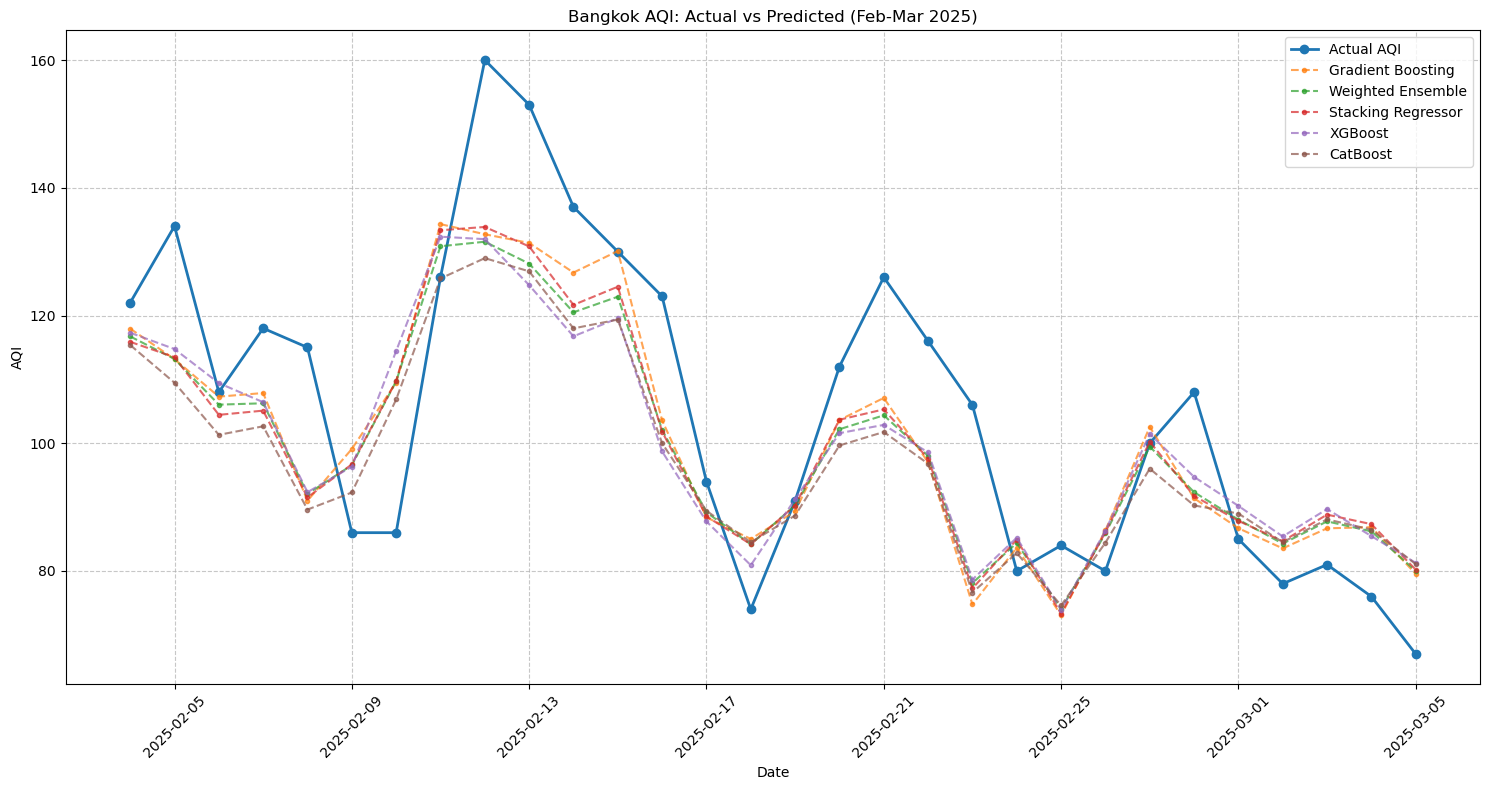

In [36]:
# Plot future predictions
plt.figure(figsize=(15, 8))
plt.plot(future_data['date'], future_data['AQI'], marker='o', linestyle='-', linewidth=2, label='Actual AQI')

# Plot predictions from best models
for model in best_models:
    plt.plot(future_data['date'], future_data[f'AQI_pred_{model.replace(" ", "_")}'], 
             marker='.', linestyle='--', alpha=0.7, label=f'{model}')

plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Bangkok AQI: Actual vs Predicted (Feb-Mar 2025)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_results/future_predictions.png')

print("\nModel building, evaluation, and future predictions completed successfully.")
print("Results and visualizations saved to 'model_results' directory.")


Model building, evaluation, and future predictions completed successfully.
Results and visualizations saved to 'model_results' directory.


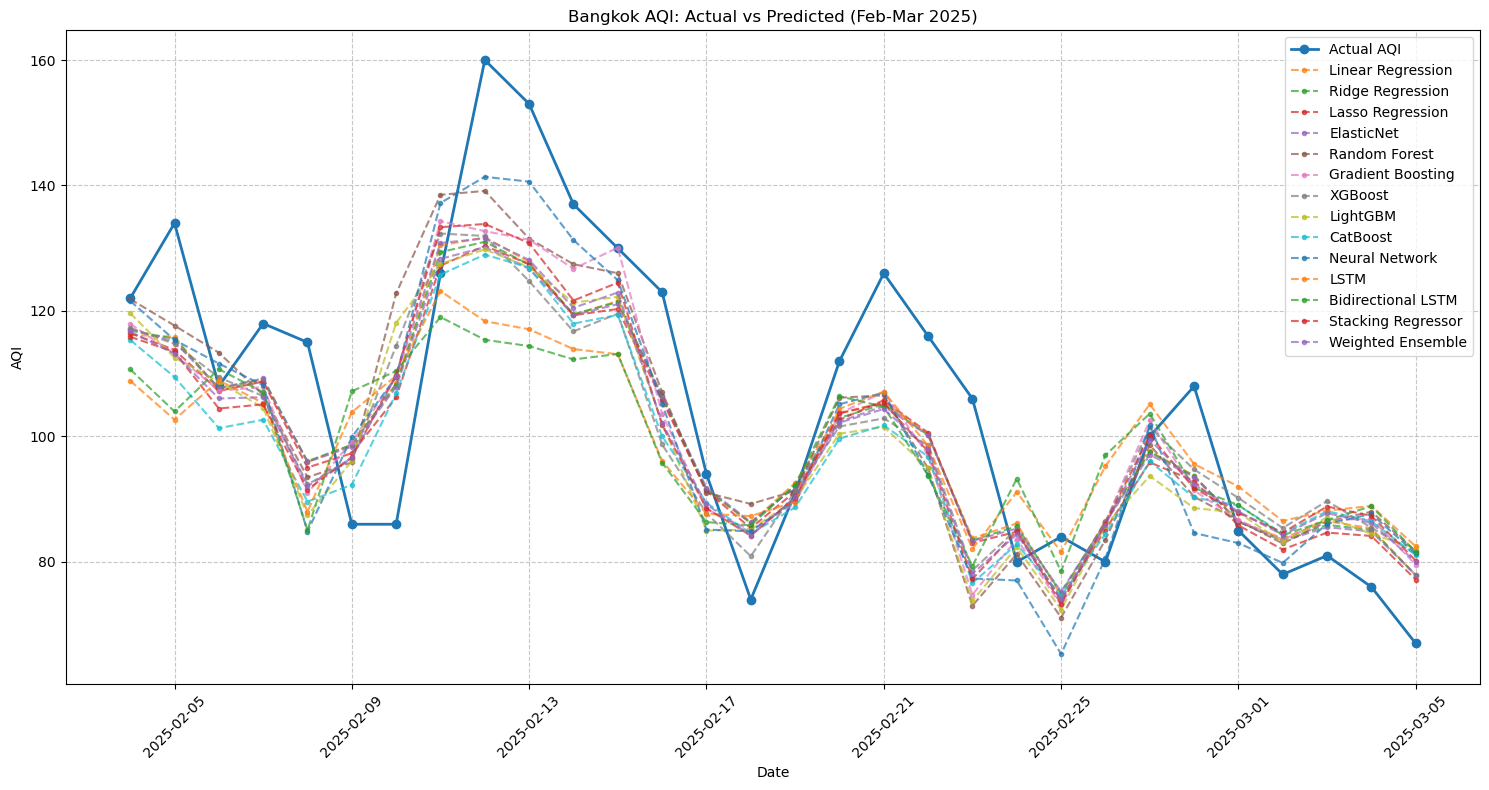

In [37]:
# Plot future predictions
plt.figure(figsize=(15, 8))
plt.plot(future_data['date'], future_data['AQI'], marker='o', linestyle='-', linewidth=2, label='Actual AQI')

# Retrieve all model names from the future_predictions dictionary
all_model_names = list(future_predictions.keys())

# Plot predictions from all models
for model in all_model_names:
    plt.plot(future_data['date'], future_data[f'AQI_pred_{model.replace(" ", "_")}'], 
             marker='.', linestyle='--', alpha=0.7, label=model)

plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Bangkok AQI: Actual vs Predicted (Feb-Mar 2025)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_results/future_predictions.png')

print("\nModel building, evaluation, and future predictions completed successfully.")
print("Results and visualizations saved to 'model_results' directory.")
